In [1]:
# Installing the necessary libraries

In [ ]:
pip install pandas numpy matplotlib seaborn pyarrow

In [40]:
# Import core packages


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Jupyter niceties
pd.set_option('display.precision', 3)
sns.set_theme(style="whitegrid")

In [41]:
# Importing the dataset CSV file


DATA_PATH = "bekalu_data.csv"
df = pd.read_csv(DATA_PATH)

print(f"Rows: {len(df):,}  |  Columns: {len(df.columns)}")
df.head()


Rows: 33,750  |  Columns: 13


exp_id           model          experiment_type  condition  \
0  00a84930c12034b1c4c3cf51b205de1c087ebfe0  gemma-3-27b-it  risk_aversion_uncertain  uncertain   
1  00a84930c12034b1c4c3cf51b205de1c087ebfe0  gemma-3-27b-it  risk_aversion_uncertain  uncertain   
2  00a84930c12034b1c4c3cf51b205de1c087ebfe0  gemma-3-27b-it  risk_aversion_uncertain  uncertain   
3  00a84930c12034b1c4c3cf51b205de1c087ebfe0  gemma-3-27b-it  risk_aversion_uncertain  uncertain   
4  00a84930c12034b1c4c3cf51b205de1c087ebfe0  gemma-3-27b-it  risk_aversion_uncertain  uncertain   

        memory_type  round  player_choice  partner_choice  player_score  partner_score  \
0  long_term_memory      1              1               0             0              5   
1  long_term_memory      2              1               0             0              5   
2  long_term_memory      3              1               0             0              5   
3  long_term_memory      4              1               0             0              5   
4  long_term_memory      5              1               0             0              5   

   total_tokens_used  player_choice_lag1  partner_choice_lag1  
0                178                 NaN                  NaN  
1                384                 1.0                  0.0  
2                614                 1.0                  0.0  
3                868                 1.0                  0.0  
4               1146                 1.0                  0.0

In [42]:
# Quick structure check

df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33750 entries, 0 to 33749
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   exp_id               33750 non-null  object 
 1   model                33750 non-null  object 
 2   experiment_type      33750 non-null  object 
 3   condition            33750 non-null  object 
 4   memory_type          33750 non-null  object 
 5   round                33750 non-null  int64  
 6   player_choice        33750 non-null  int64  
 7   partner_choice       33750 non-null  int64  
 8   player_score         33750 non-null  int64  
 9   partner_score        33750 non-null  int64  
 10  total_tokens_used    33750 non-null  int64  
 11  player_choice_lag1   33075 non-null  float64
 12  partner_choice_lag1  33075 non-null  float64
dtypes: float64(2), int64(6), object(5)
memory usage: 3.3+ MB


In [43]:
# Overall descriptive statistics


numeric_cols = ["player_choice", "partner_choice",
                "player_score", "partner_score", "total_tokens_used"]

df[numeric_cols].describe().T


count       mean        std    min      25%     50%       75%      max
player_choice      33750.0      0.310      0.462    0.0     0.00     0.0      1.00      1.0
partner_choice     33750.0      0.166      0.372    0.0     0.00     0.0      0.00      1.0
player_score       33750.0      1.281      1.385    0.0     1.00     1.0      1.00      5.0
partner_score      33750.0      1.997      1.775    0.0     1.00     1.0      3.00      5.0
total_tokens_used  33750.0  11262.033  10180.928  153.0  4174.25  8626.0  14072.75  57590.0

In [44]:
#  Response-rate sanity check  (Table 4-1)
resp_tbl = pd.DataFrame({
    "Item": ["Experimental games", "Rounds per game", "Decision records"],
    "Planned": [675, 50, 675*50],
    "Collected": [
        df["exp_id"].nunique(),
        df.groupby("exp_id")["round"].nunique().min(),
        len(df)
    ]
})
resp_tbl["Completion rate"] = resp_tbl["Collected"] / resp_tbl["Planned"]
resp_tbl


Item  Planned  Collected  Completion rate
0  Experimental games      675        675              1.0
1     Rounds per game       50         50              1.0
2    Decision records    33750      33750              1.0

In [45]:
# Cooperation rate overall & by memory type

# Overall
coop_rate = df["player_choice"].mean()
print(f"Overall cooperation rate: {coop_rate:.3f}")

# By memory_type
coop_mem = (
    df.groupby("memory_type")["player_choice"]
      .mean()
      .rename("coop_rate")
      .reset_index()
      .sort_values("coop_rate", ascending=False)
)
coop_mem


Overall cooperation rate: 0.310


memory_type  coop_rate
1          no_memory      0.358
2  short_term_memory      0.309
0   long_term_memory      0.262

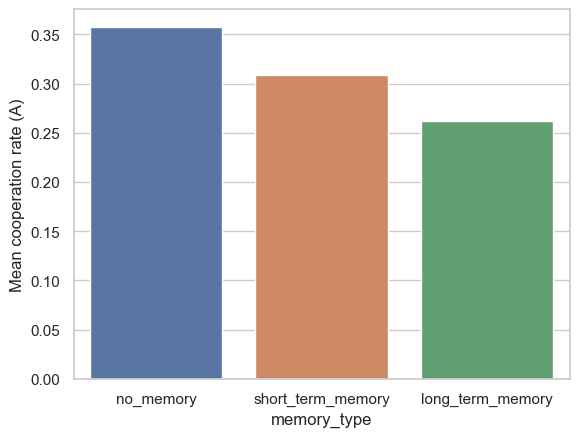

In [46]:
# Barplot for the previous step

sns.barplot(data=coop_mem, x="memory_type", y="coop_rate")
plt.ylabel("Mean cooperation rate (A)")
plt.show()


In [47]:
# Cooperation rate overall & by model

# Overall
coop_rate = df["player_choice"].mean()
print(f"Overall cooperation rate: {coop_rate:.3f}")

# By model
coop_mem = (
    df.groupby("model")["player_choice"]
      .mean()
      .rename("coop_rate")
      .reset_index()
      .sort_values("coop_rate", ascending=False)
)
coop_mem


Overall cooperation rate: 0.310


model  coop_rate
6          gemma-3-1b-it      0.738
1    gemini-1.5-flash-8b      0.503
3       gemini-2.0-flash      0.328
0       gemini-1.5-flash      0.321
5         gemma-3-12b-it      0.261
7         gemma-3-27b-it      0.220
2         gemini-1.5-pro      0.157
8          gemma-3-4b-it      0.149
4  gemini-2.0-flash-lite      0.110

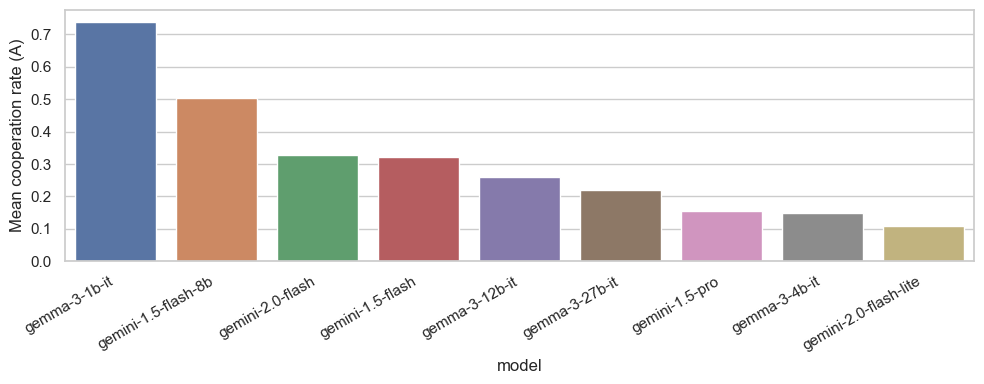

In [48]:
# Barplot for the previous step


fig, ax = plt.subplots(figsize=(10, 4))             # ❶ wider figure
sns.barplot(data=coop_mem, x="model", y="coop_rate", ax=ax)

ax.set_ylabel("Mean cooperation rate (A)")

# ❷ rotate & right-align tick labels
ax.set_xticklabels(ax.get_xticklabels(),
                   rotation=30,                     # 30–45° is common
                   ha='right')                      # horizontal alignment

fig.tight_layout()                                  # ❸ keep labels inside canvas
plt.show()

In [49]:
# Cooperation rate by scenario (experiment_type x condition)


coop_scen = (
    df.groupby(["experiment_type", "condition"])["player_choice"]
      .mean()
      .rename("coop_rate")
      .reset_index()
      .sort_values("coop_rate", ascending=False)
)

coop_scen


experiment_type          condition  coop_rate
19             risk_aversion_uncertain          uncertain      0.668
18              risk_aversion_low_risk           low_risk      0.649
23        temporal_preferences_delayed            delayed      0.547
0          default_bias_default_mutual     default_mutual      0.453
22       social_preferences_low_status         low_status      0.414
14    peer_influence_strong_majority_a  strong_majority_a      0.382
3      emotional_priming_collaborative      collaborative      0.313
6            emotional_priming_neutral            neutral      0.295
13      peer_influence_split_influence    split_influence      0.295
15   political_cultural_collectivistic     collectivistic      0.291
10           peer_influence_majority_a         majority_a      0.288
5            emotional_priming_empathy            empathy      0.286
7             framing_effects_negative           negative      0.283
9             framing_effects_positive           positive      0.283
2              default_bias_no_default         no_default      0.259
4        emotional_priming_competitive        competitive      0.256
8              framing_effects_neutral            neutral      0.241
12         peer_influence_no_influence       no_influence      0.236
17             risk_aversion_high_risk          high_risk      0.229
24      temporal_preferences_immediate          immediate      0.219
16  political_cultural_individualistic    individualistic      0.190
11           peer_influence_majority_b         majority_b      0.188
1            default_bias_default_self       default_self      0.184
20     social_preferences_equal_status       equal_status      0.170
21      social_preferences_high_status        high_status      0.124

In [50]:
# Player vs partner scores (overall & by memory)


score_stats = (
    df.groupby("memory_type")[["player_score", "partner_score"]]
      .mean()
      .rename(columns=lambda c: f"mean_{c}")
      .reset_index()
)

score_stats


memory_type  mean_player_score  mean_partner_score
0   long_term_memory              1.328               1.828
1          no_memory              1.227               2.167
2  short_term_memory              1.287               1.996

In [51]:
# Token consumption by memory type

token_mem = (
    df.groupby("memory_type")["total_tokens_used"]
      .mean()
      .rename("mean_tokens")
      .reset_index()
)
token_mem


memory_type  mean_tokens
0   long_term_memory    18269.407
1          no_memory     7314.788
2  short_term_memory     8201.903

In [52]:
# Pivot summary table for the paper



summary_tbl = (
    df.groupby("memory_type")
      .agg(
          coop_rate=("player_choice", "mean"),
          player_score_mean=("player_score", "mean"),
          tokens_mean=("total_tokens_used", "mean")
      )
      .round(3)
)
summary_tbl


coop_rate  player_score_mean  tokens_mean
memory_type                                                 
long_term_memory       0.262              1.328    18269.407
no_memory              0.358              1.227     7314.788
short_term_memory      0.309              1.287     8201.903

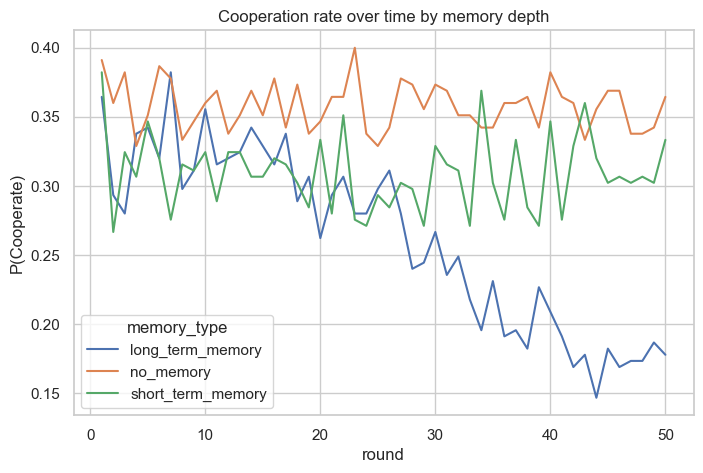

In [53]:
# (Preview) Cooperation trajectory over 50 rounds



traj = (
    df.groupby(["round", "memory_type"])["player_choice"]
      .mean()
      .reset_index()
)

plt.figure(figsize=(8,5))
sns.lineplot(data=traj, x="round", y="player_choice", hue="memory_type")
plt.ylabel("P(Cooperate)")
plt.title("Cooperation rate over time by memory depth")
plt.show()


### Descriptive Part

In [54]:
#  Response-rate sanity check  (Table 4-1)
resp_tbl = pd.DataFrame({
    "Item": ["Experimental games", "Rounds per game", "Decision records"],
    "Planned": [675, 50, 675*50],
    "Collected": [
        df["exp_id"].nunique(),
        df.groupby("exp_id")["round"].nunique().min(),
        len(df)
    ]
})
resp_tbl["Completion rate"] = resp_tbl["Collected"] / resp_tbl["Planned"]
resp_tbl


Item  Planned  Collected  Completion rate
0  Experimental games      675        675              1.0
1     Rounds per game       50         50              1.0
2    Decision records    33750      33750              1.0

In [55]:
#  “Demographic” profile of experiments  (Table 4-2)
demo_tbl = (
    df.groupby("memory_type")["exp_id"].nunique()
      .rename("Experiments")
      .reset_index()
)
demo_tbl["Share %"] = 100 * demo_tbl["Experiments"] / demo_tbl["Experiments"].sum()
print("Memory-type balance:")
display(demo_tbl)

model_counts = df.groupby("model")["exp_id"].nunique().rename("n")
print("\nModel balance (n per checkpoint):")
display(model_counts.to_frame())


Memory-type balance:


memory_type  Experiments  Share %
0   long_term_memory          225   33.333
1          no_memory          225   33.333
2  short_term_memory          225   33.333


Model balance (n per checkpoint):


n
model                    
gemini-1.5-flash       75
gemini-1.5-flash-8b    75
gemini-1.5-pro         75
gemini-2.0-flash       75
gemini-2.0-flash-lite  75
gemma-3-12b-it         75
gemma-3-1b-it          75
gemma-3-27b-it         75
gemma-3-4b-it          75

In [56]:
#  Descriptive stats overall & by memory type  (Table 4-3)
desc_overall = (
    df[["player_choice", "player_score", "total_tokens_used"]]
      .agg(["mean", "std"])
      .T
)
desc_overall

desc_mem = (
    df.groupby("memory_type")
      .agg(
          coop_rate=("player_choice", "mean"),
          player_score_mean=("player_score", "mean"),
          tokens_mean=("total_tokens_used", "mean")
      )
      .round(3)
)
desc_mem


coop_rate  player_score_mean  tokens_mean
memory_type                                                 
long_term_memory       0.262              1.328    18269.407
no_memory              0.358              1.227     7314.788
short_term_memory      0.309              1.287     8201.903

In [57]:
# Cooperation rate by scenario (Table 4-4)
coop_scen = (
    df.groupby(["experiment_type", "condition"])["player_choice"]
      .mean()
      .rename("coop_rate")
      .reset_index()
      .sort_values("coop_rate", ascending=False)
)

# Display full table
from IPython.display import display, HTML

print("Cooperation Rate by Scenario (Table 4-4):")
display(HTML(coop_scen.to_html(index=False)))


Cooperation Rate by Scenario (Table 4-4):


In [58]:
#  Score comparison player vs partner
score_tbl = (
    df[["player_score", "partner_score"]]
      .describe()
      .loc[["mean", "std"]]
      .round(3)
)
score_tbl


player_score  partner_score
mean         1.281          1.997
std          1.385          1.775

In [59]:

# Model-level co-operation rate and mean score  (Table 4-6)

model_stats = (
    df.groupby("model")
      .agg(
          coop_rate=("player_choice", "mean"),
          player_score_mean=("player_score", "mean")
      )
      .reset_index()
      .sort_values("coop_rate", ascending=False)        # rank by co-op
      .reset_index(drop=True)
)

# add a rank column for clarity
model_stats.insert(0, "Rank_by_P(A)", model_stats.index + 1)

display(model_stats)


Rank_by_P(A)                  model  coop_rate  player_score_mean
0             1          gemma-3-1b-it      0.738              1.083
1             2    gemini-1.5-flash-8b      0.503              1.160
2             3       gemini-2.0-flash      0.328              1.318
3             4       gemini-1.5-flash      0.321              1.270
4             5         gemma-3-12b-it      0.261              1.316
5             6         gemma-3-27b-it      0.220              1.348
6             7         gemini-1.5-pro      0.157              1.339
7             8          gemma-3-4b-it      0.149              1.343
8             9  gemini-2.0-flash-lite      0.110              1.349

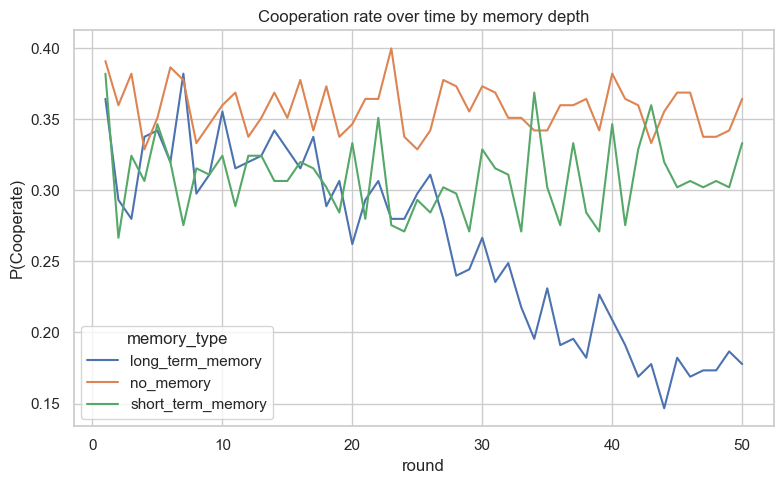

In [60]:
# Cooperation trajectory line-plot (optional figure)
traj = (
    df.groupby(["round", "memory_type"])["player_choice"]
      .mean()
      .reset_index()
)

plt.figure(figsize=(8,5))
sns.lineplot(data=traj, x="round", y="player_choice", hue="memory_type")
plt.ylabel("P(Cooperate)")
plt.title("Cooperation rate over time by memory depth")
plt.tight_layout()
plt.show()


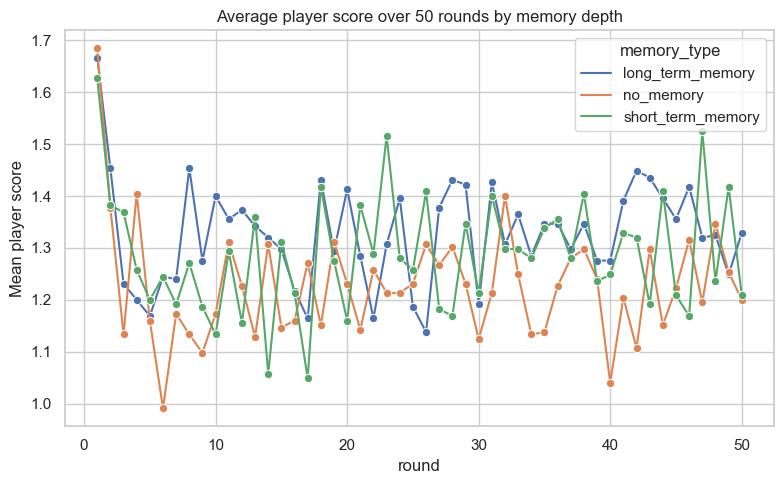

In [61]:
# Trend of PLAYER SCORE (and optional partner score) vs. round

# ---------- (a) Player score by memory depth ----------
score_traj = (
    df.groupby(["round", "memory_type"])["player_score"]
      .mean()
      .reset_index()
)

plt.figure(figsize=(8,5))
sns.lineplot(
    data=score_traj,
    x="round",
    y="player_score",
    hue="memory_type",
    marker="o"
)
plt.ylabel("Mean player score")
plt.title("Average player score over 50 rounds by memory depth")
plt.tight_layout()
plt.show()

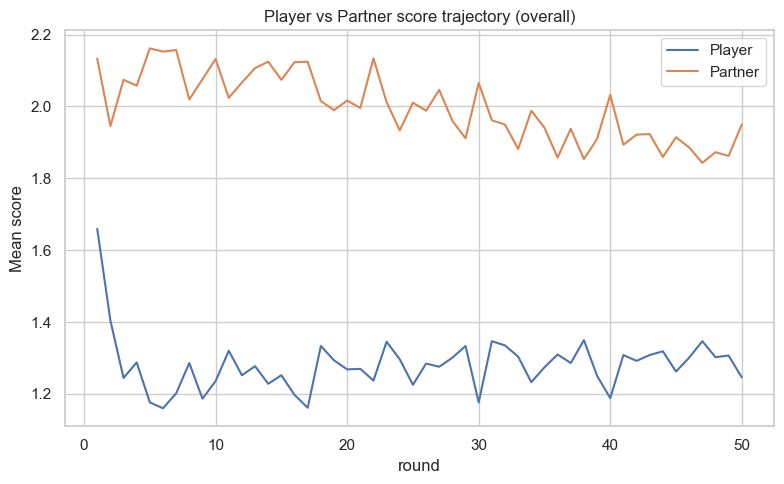

In [62]:

# ---------- (b) OPTIONAL: include partner score on the same axes ----------


score_traj_partner = (
    df.groupby(["round"])  # overall mean regardless of memory type
      .agg(
          player_score=("player_score", "mean"),
          partner_score=("partner_score", "mean")
      )
      .reset_index()
)

plt.figure(figsize=(8,5))
sns.lineplot(data=score_traj_partner, x="round", y="player_score", label="Player")
sns.lineplot(data=score_traj_partner, x="round", y="partner_score", label="Partner")
plt.ylabel("Mean score")
plt.title("Player vs Partner score trajectory (overall)")
plt.tight_layout()
plt.show()


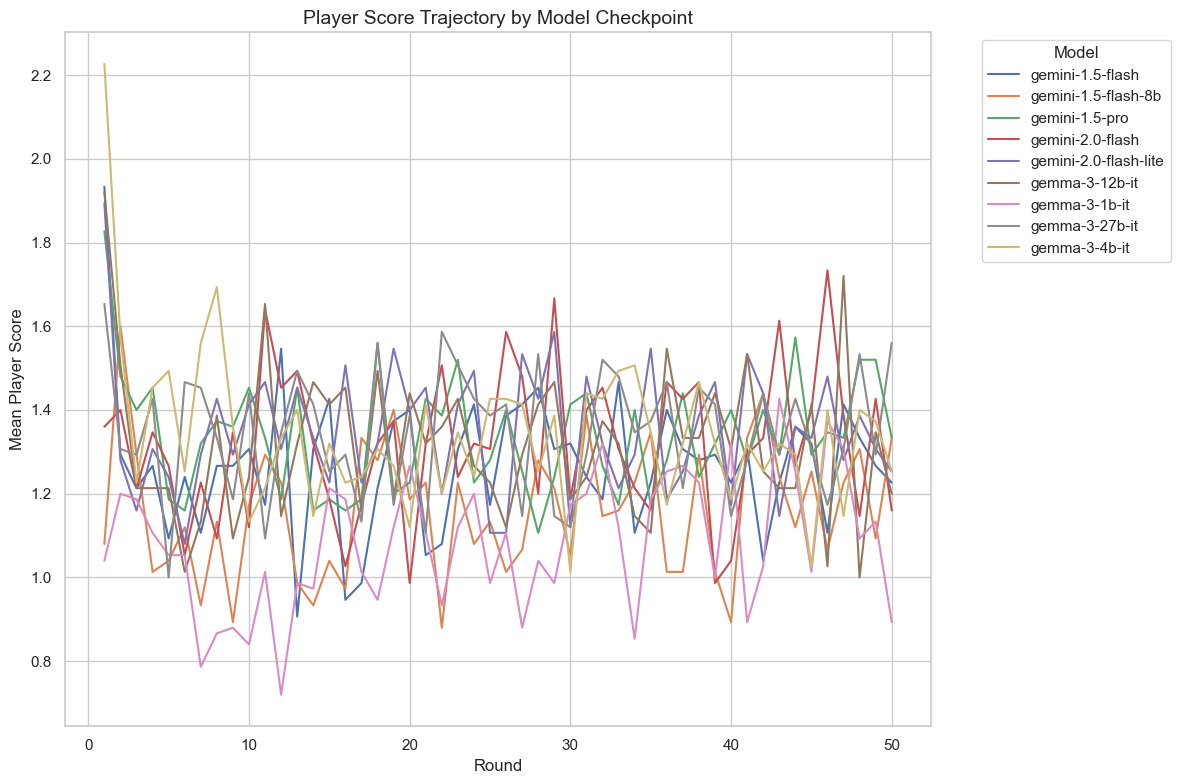

In [63]:

# Figure 4.4: Player score trajectory by model checkpoint

# Compute mean player score by round and model
score_model_traj = (
    df.groupby(['round', 'model'])['player_score']
      .mean()
      .reset_index()
)

# Plot trajectories for each model
plt.figure(figsize=(12, 8))
sns.lineplot(
    data=score_model_traj,
    x='round',
    y='player_score',
    hue='model',
    legend='full',
    linewidth=1.5
)
plt.title('Player Score Trajectory by Model Checkpoint', fontsize=14)
plt.xlabel('Round', fontsize=12)
plt.ylabel('Mean Player Score', fontsize=12)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


### Correlation Analysis

In [64]:
# Select variables to correlate
# ---------------------------------------------------------------------
# Build correlation DataFrame with the correct numeric variables
# ---------------------------------------------------------------------
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Specify the numeric columns that do exist
num_cols = ["player_score", "total_tokens_used"]   # <-- your pay-off column

# 2. Create coop_rate if necessary (mean P(cooperate) within each game)
if "coop_rate" not in df.columns:
    df["coop_rate"] = (
        df.sort_values(["exp_id", "round"])
          .groupby("exp_id")["player_choice"]
          .transform("mean")
    )
num_cols.insert(0, "coop_rate")

# 3. Dummy-code the two main treatments
dummies = pd.get_dummies(df[["memory_type", "condition"]], drop_first=True)

# 4. Combine numeric outcomes + dummies into one DataFrame
corr_df = pd.concat([df[num_cols], dummies], axis=1)

# 5. Pearson correlation matrix (upper triangle, coloured)
corr_mat = corr_df.corr(method="pearson").round(3)
mask = np.triu(np.ones_like(corr_mat, dtype=bool))

# Display styled correlation matrix in Jupyter
styled_corr = (
    corr_mat.style
    .background_gradient(cmap="coolwarm", vmin=-1, vmax=1)
    .format("{:.2f}")
    .set_properties(**{"text-align": "center"})
    .set_caption("Pearson correlation matrix")
)
display(styled_corr)

# 6. Save heatmap as PNG
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_mat,
    mask=mask,
    cmap="coolwarm",
    annot=True,
    fmt=".2f",
    square=True,
    cbar_kws={"shrink": .75},
    vmin=-1,
    vmax=1,
    linewidths=0.5,
    annot_kws={"size": 8}
)
plt.title("Pearson Correlation Matrix", fontsize=14)
plt.tight_layout()
plt.savefig("corr_matrix_plot.png", dpi=300)
plt.close()

# 7. Dump raw correlation matrix to CSV file
corr_mat.to_csv("corr_matrix_table.csv", index=True)


### Inferential (Regression Analysis)

In [28]:
#  Install needed packages

In [52]:
pip install statsmodels linearmodels

     ---------------------------------------- 1.7/1.7 MB 1.8 MB/s eta 0:00:00
     ---------------------------------------- 43.9/43.9 kB 2.2 MB/s eta 0:00:00
     ---------------------------------------- 2.7/2.7 MB 2.8 MB/s eta 0:00:00
     -------------------------------------- 115.7/115.7 kB 2.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [65]:
# Import needed packages



import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.genmod.generalized_estimating_equations import GEE
from statsmodels.genmod.cov_struct import Exchangeable

# rpy2 for calling R’s pglm
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()

from IPython.display import display
pd.set_option('display.width', 100)


In [31]:
pip install rpy2

     ------------------------------------ 221.0/221.0 kB 842.9 kB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     -------------------------------------- 347.8/347.8 kB 2.7 MB/s eta 0:00:00
  Created wheel for rpy2: filename=rpy2-3.5.17-py3-none-any.whl size=221382 sha256=3736149830a1b9d58d7b3ffbe52753b1f9b794ca2c24ba614bd1ad11e385a80a
  Stored in directory: c:\users\bek\appdata\local\pip\cache\wheels\a0\5c\5e\89b5e468237f3a957bab3ac09c58be7db9b0b6ffd1be58c2eb
Successfully built rpy2
Note: you may need to restart the kernel to use updated packages.


In [30]:
# Install R’s pglm and the rpy2 bridge (run once)

In [66]:
# Set up rpy2 and load data into R

from rpy2.robjects import r, pandas2ri

# Activate the pandas ↔ R DataFrame converter
pandas2ri.activate()


# Convert to an R data.frame
r_df = pandas2ri.py2rpy(df)
r.assign("rdf", r_df)



<rpy2.robjects.vectors.DataFrame object at 0x0000013FEAE88240> [RTYPES.VECSXP]
R classes: ('data.frame',)
[StrSexpVe..., StrSexpVe..., StrSexpVe..., StrSexpVe..., ..., IntSexpVe..., FloatSexp..., FloatSexp..., FloatSexp...]
  exp_id: <class 'numpy.ndarray'>
  array(['00a84930c12034b1c4c3cf51b205de1c087ebfe0',
       '00a84930c12034b1c4c3cf51b205de1c087ebfe0',
       '00a84930c12034b1c4c3cf51b205de1c087ebfe0', ...,
       'feaa420b09057a87d12d51534e64adbc1290e7d9',
       'feaa420b09057a87d12d51534e64adbc1290e7d9',
       'feaa420b09057a87d12d51534e64adbc1290e7d9'], dtype='<U40')
  model: <class 'numpy.ndarray'>
  array(['gemma-3-27b-it', 'gemma-3-27b-it', 'gemma-3-27b-it', ...,
       'gemini-2.0-flash', 'gemini-2.0-flash', 'gemini-2.0-flash'],
      dtype='<U21')
  experiment_type: <class 'numpy.ndarray'>
  array(['risk_aversion_uncertain', 'risk_aversion_uncertain',
       'risk_aversion_uncertain', ..., 'peer_influence_strong_majority_a',
       'peer_influence_strong_majority_a',
       'peer_influence_strong_majority_a'], dtype='<U34')
  condition: <class 'numpy.ndarray'>
  array(['uncertain', 'uncertain', 'uncertain', ..., 'strong_majority_a',
       'strong_majority_a', 'strong_majority_a'], dtype='<U17')
...
  round: <class 'rpy2.robjects.vectors.IntVector'>
  <rpy2.robjects.vectors.IntVector object at 0x0000013FEAF02B80> [RTYPES.INTSXP]
R classes: ('integer',)
[178, 384, 614, 868, ..., 48578, 50240, 51871, 53519]
  player_choice: <class 'numpy.ndarray'>
  array([nan,  1.,  1., ...,  0.,  0.,  0.])
  partner_choice: <class 'numpy.ndarray'>
  array([nan,  0.,  0., ...,  0.,  0.,  0.])
  player_score: <class 'numpy.ndarray'>
  array([0.54, 0.54, 0.54, ..., 0.34, 0.34, 0.34])

In [ ]:
# Install and load the pglm package in R
r('if (!requireNamespace("pglm", quietly=TRUE)) '
  ' install.packages("pglm", repos="https://cloud.r-project.org")')
r('library(pglm)')


In [67]:
# Convert to categorical



for col in ['memory_type','experiment_type','condition','model','exp_id']:
    df[col] = df[col].astype('category')

# Create lag for dynamic specification
df = df.sort_values(['exp_id','round'])
df['choice_lag1'] = df.groupby('exp_id')['player_choice'].shift(1).fillna(0)


In [68]:
# Cluster‐robust GLM‐logit (no collinearity)

import statsmodels.api as sm
import statsmodels.formula.api as smf


# We drop C(experiment_type) & use only C(condition) to avoid nested dummy collinearity
formula2 = "player_choice ~ C(memory_type)*C(condition) + round"

glm_bin2 = smf.glm(
    formula = formula2,
    data    = df,
    family  = sm.families.Binomial()
).fit(
    cov_type = 'cluster',
    cov_kwds = {'groups': df['model'], 'ddof':1}
)

print(glm_bin2.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:          player_choice   No. Observations:                33750
Model:                            GLM   Df Residuals:                    33677
Model Family:                Binomial   Df Model:                           72
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -19023.
Date:                Sat, 17 May 2025   Deviance:                       38047.
Time:                        20:16:48   Pearson chi2:                 3.37e+04
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1045
Covariance Type:              cluster                                         
                                                                            coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------

                 Generalized Linear Model Regression Results                  
Dep. Variable:          player_choice   No. Observations:                33750
Model:                            GLM   Df Residuals:                    33677
Model Family:                Binomial   Df Model:                           72
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -19023.
Date:                Sat, 17 May 2025   Deviance:                       38047.
Time:                        22:43:21   Pearson chi2:                 3.37e+04
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1045
Covariance Type:              cluster                                         
                                                                            coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------

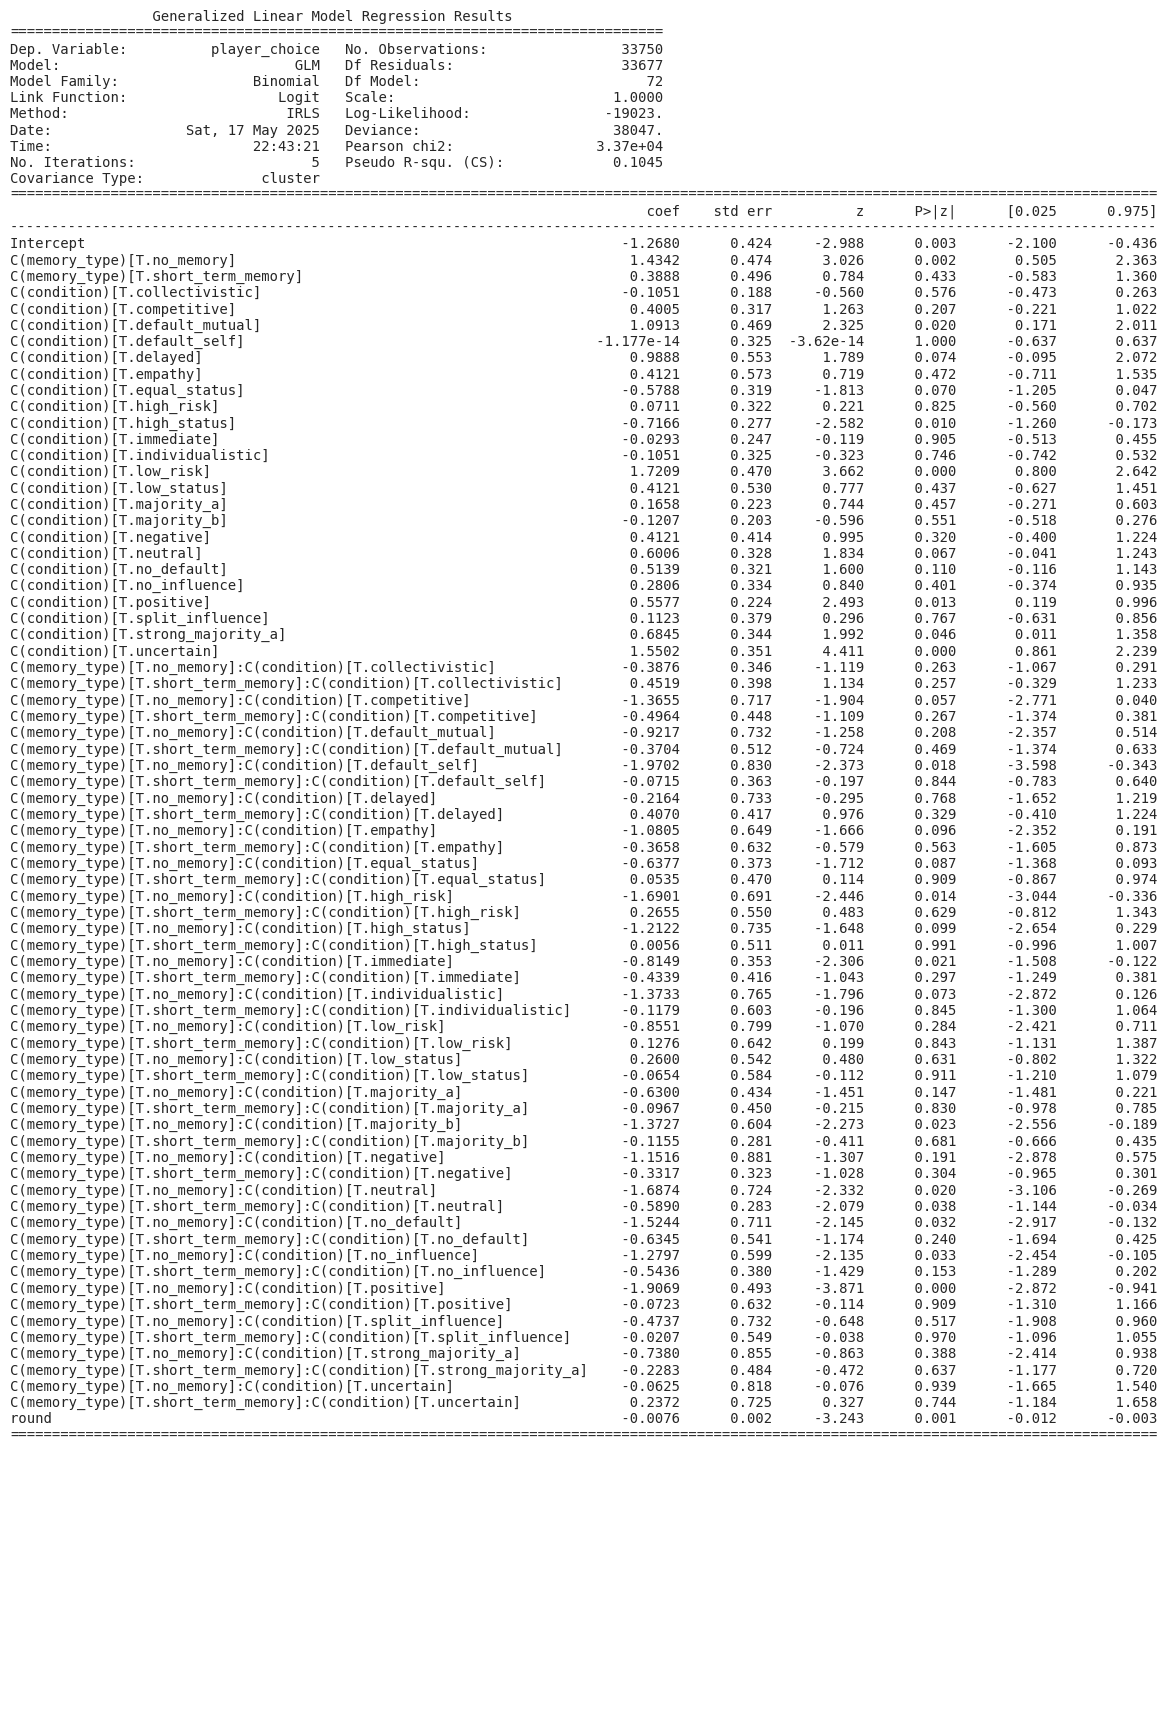

In [113]:
# Cluster‐robust GLM‐logit (no collinearity)
# We drop C(experiment_type) & use only C(condition) to avoid nested dummy collinearity

# —————— 1. Fit cluster‐robust GLM–logit ——————
formula2 = "player_choice ~ C(memory_type)*C(condition) + round"
glm_bin2 = smf.glm(
    formula = formula2,
    data    = df,
    family  = sm.families.Binomial()
).fit(
    cov_type = 'cluster',
    cov_kwds = {'groups': df['model'], 'ddof': 1}
)

# —————— 2. Print summary to console ——————
print(glm_bin2.summary())

# —————— 3. Dump summary text to .txt ——————
summary_str = glm_bin2.summary().as_text()
with open("glm_bin2_summary.txt", "w") as f:
    f.write(summary_str)

# —————— 4. Save coefficients table to Excel ——————
coef_df = glm_bin2.summary2().tables[1]
coef_df.to_excel("glm_bin2_coefficients.xlsx", index=True)

# —————— 5. Also save full summary as Excel ——————
full_summary_df = glm_bin2.summary2().tables[0].copy()
with pd.ExcelWriter("glm_bin2_full_summary.xlsx") as writer:
    full_summary_df.to_excel(writer, sheet_name="Model Info")
    coef_df.to_excel(writer, sheet_name="Coefficients")

# —————— 6. Render the full summary (header + table) as a PNG image ——————
lines = summary_str.split('\n')
fig_height = max(6, len(lines) * 0.25)  # ~0.25" per line, min height 6"
fig, ax = plt.subplots(figsize=(8, fig_height))
ax.axis('off')
ax.text(
    0, 1,
    summary_str,
    family='monospace',
    fontsize=10,
    va='top',
)
fig.savefig("glm_bin2_summary.png", bbox_inches='tight', dpi=300)


In [69]:
#  GEE‐logit (exchangeable by game)

res_gee2 = GEE.from_formula(
    formula    = formula2,
    groups     = "exp_id",
    data       = df,
    family     = sm.families.Binomial(),
    cov_struct = Exchangeable()
).fit()

print(res_gee2.summary())


                               GEE Regression Results                              
Dep. Variable:               player_choice   No. Observations:                33750
Model:                                 GEE   No. clusters:                      675
Method:                        Generalized   Min. cluster size:                  50
                      Estimating Equations   Max. cluster size:                  50
Family:                           Binomial   Mean cluster size:                50.0
Dependence structure:         Exchangeable   Num. iterations:                    26
Date:                     Sat, 17 May 2025   Scale:                           1.000
Covariance type:                    robust   Time:                         20:16:58
                                                                            coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------

                               GEE Regression Results                              
Dep. Variable:               player_choice   No. Observations:                33750
Model:                                 GEE   No. clusters:                      675
Method:                        Generalized   Min. cluster size:                  50
                      Estimating Equations   Max. cluster size:                  50
Family:                           Binomial   Mean cluster size:                50.0
Dependence structure:         Exchangeable   Num. iterations:                    26
Date:                     Sun, 18 May 2025   Scale:                           1.000
Covariance type:                    robust   Time:                         02:32:25
                                                                            coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------

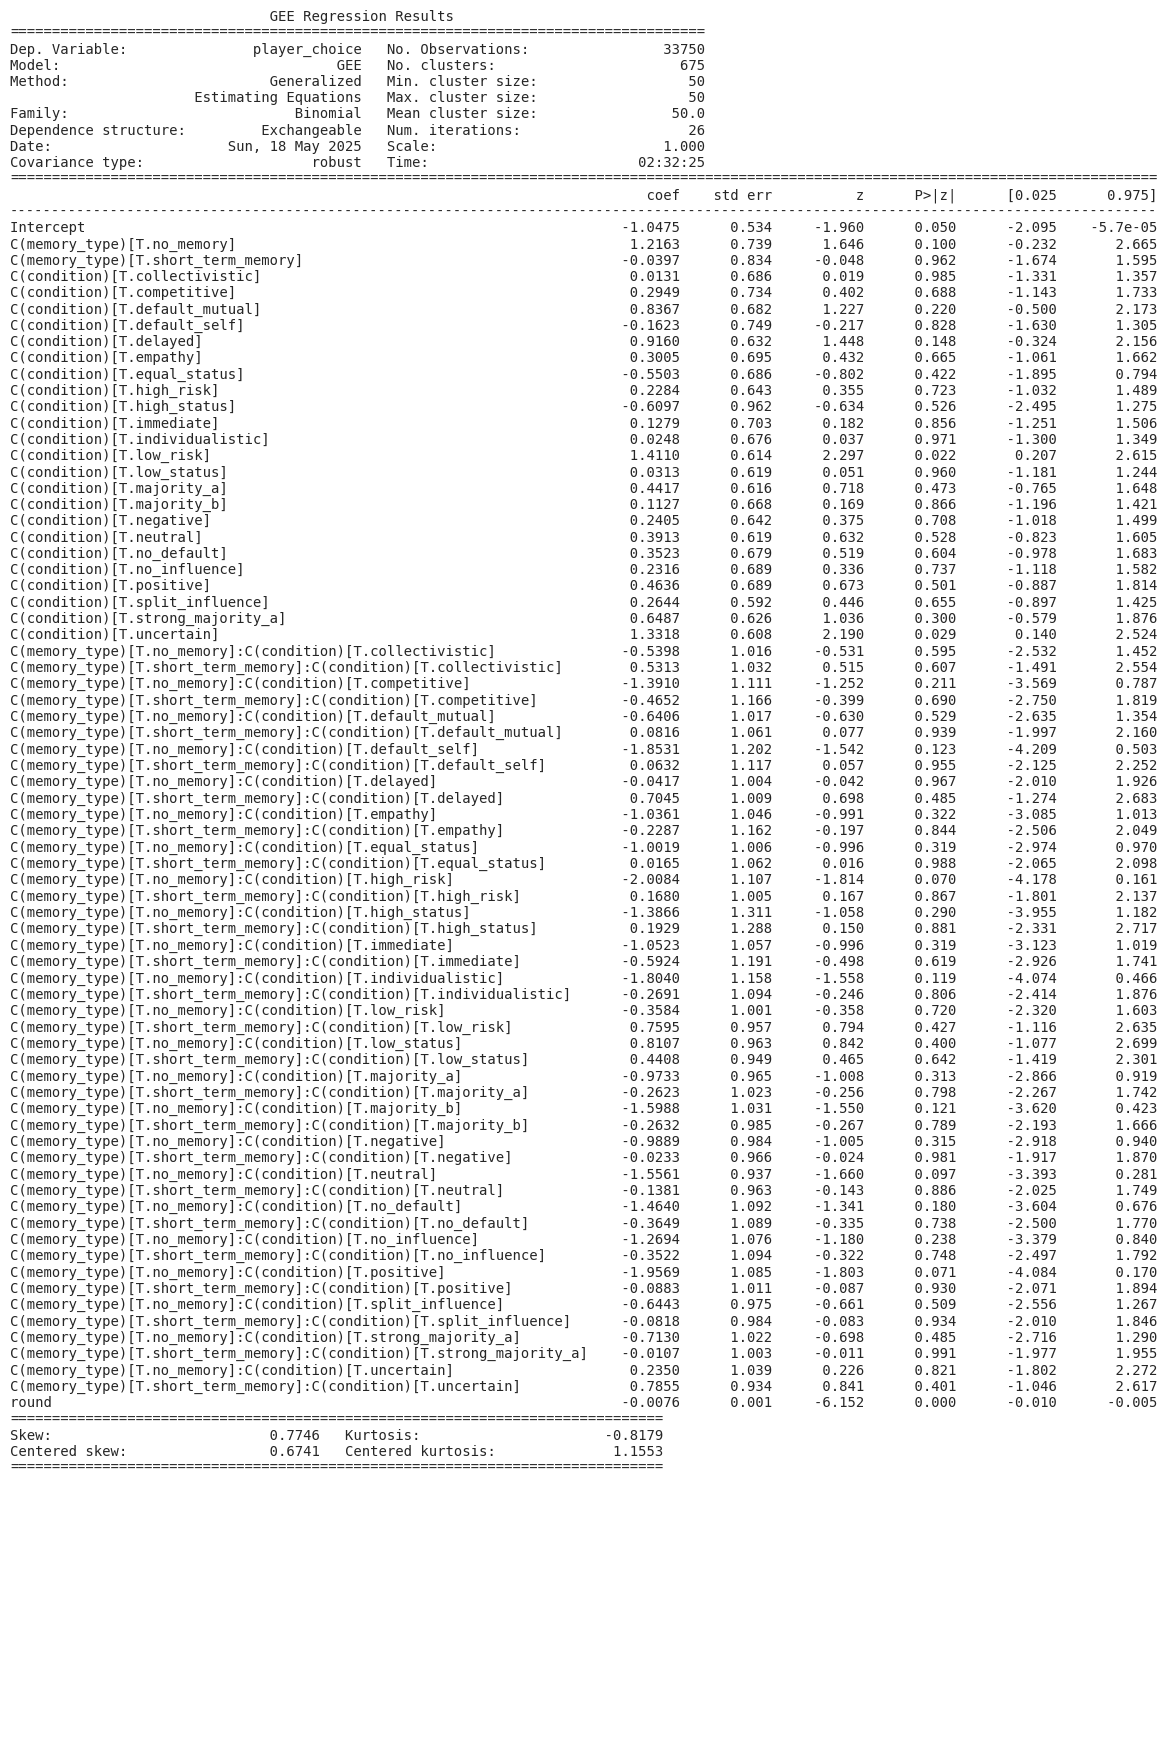

In [116]:
# GEE‐logit (exchangeable by game)

from statsmodels.genmod.generalized_estimating_equations import GEE
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.cov_struct import Exchangeable
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

# GEE‐logit (exchangeable by game)
res_gee2 = GEE.from_formula(
    formula    = formula2,
    groups     = "exp_id",
    data       = df,
    family     = sm.families.Binomial(),
    cov_struct = Exchangeable()
).fit()

# Print summary to console
print(res_gee2.summary())

# Dump summary to file
with open("res_gee2_summary.txt", "w") as f:
    f.write(res_gee2.summary().as_text())

# Dump the full summary as PNG
summary_str = res_gee2.summary().as_text()
lines = summary_str.split('\n')
fig_height = max(6, len(lines) * 0.25)  # ~0.25" per line, min height 6"
fig, ax = plt.subplots(figsize=(8, fig_height))
ax.axis('off')
ax.text(
    0, 1,
    summary_str,
    family='monospace',
    fontsize=10,
    va='top',
)
fig.savefig("res_gee2_summary.png", bbox_inches='tight', dpi=300)

# Dump coefficients table to Excel
gee_table = res_gee2.summary().tables[1]
gee_data = gee_table.data[1:]              # Skip header row
gee_columns = gee_table.data[0]            # Header row
coef_df = pd.DataFrame(gee_data, columns=gee_columns)
coef_df.to_excel("res_gee2_coefficients.xlsx", index=False)


In [119]:
import numpy as np
from numpy.linalg import inv

# 1) Try the built-in qic() method, which returns (QIC, QICu) as a tuple
try:
    qic_value, qicu_value = res_gee2.qic()   # unpack the tuple
    print(f"QIC  = {qic_value:.2f}")
    print(f"QICu = {qicu_value:.2f}")
except AttributeError:
    print("No res_gee2.qic() method available in this statsmodels version.")

# 2) If we only have qic() but not qicu(), compute QICu manually
if hasattr(res_gee2, "qic"):
    try:
        # .qic() already returned both values above
        pass
    except (TypeError, ValueError):
        print("Unexpected format returned by .qic(); computing QICu manually…")
        # fall back to manual calculation below
else:
    print("Computing QICu manually…")

    # 2a) Quasi-likelihood under independence
    mu   = res_gee2.fittedvalues
    y    = res_gee2.model.endog
    fam  = res_gee2.family
    # for Binomial logit, quasi-likelihood ≈ sum[y*ln(mu)+(1−y)*ln(1−mu)]
    ql_ind = np.sum(y * np.log(mu) + (1 - y) * np.log(1 - mu))

    # 2b) “Trace term” = tr(W^{-1} M)
    #    where W = working covariance, M = robust covariance (“meat”)
    W = res_gee2.cov_struct.covariance_matrix(res_gee2.model.exog)
    M = res_gee2.cov_struct.covariance_matrix_inner(res_gee2.model.exog)
    trace_term = np.trace(inv(W) @ M)

    QICu_manual = -2 * ql_ind + 2 * trace_term
    print(f"Manual QICu = {QICu_manual:.2f}")


QIC  = 38833.96
QICu = 38380.45


C:\Users\Bek\anaconda3\lib\site-packages\statsmodels\genmod\cov_struct.py:796: FutureWarning: grid=True will become default in a future version
  warnings.warn(


                               GEE Regression Results                              
Dep. Variable:               player_choice   No. Observations:                33750
Model:                                 GEE   No. clusters:                      675
Method:                        Generalized   Min. cluster size:                  50
                      Estimating Equations   Max. cluster size:                  50
Family:                           Binomial   Mean cluster size:                50.0
Dependence structure:       Autoregressive   Num. iterations:                    47
Date:                     Sun, 18 May 2025   Scale:                           1.000
Covariance type:                    robust   Time:                         03:13:16
                                                                            coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------

C:\Users\Bek\anaconda3\lib\site-packages\statsmodels\genmod\generalized_estimating_equations.py:1934: UserWarning: QIC values obtained using scale=None are not appropriate for comparing models
  warnings.warn("QIC values obtained using scale=None are not "


AR(1) QIC  = 38750.70
AR(1) QICu = 38298.97

Comparison of QICu:
  Exchangeable QICu = 38380.45
       AR(1) QICu = 38298.97
AR(1) structure improves fit (lower QICu).


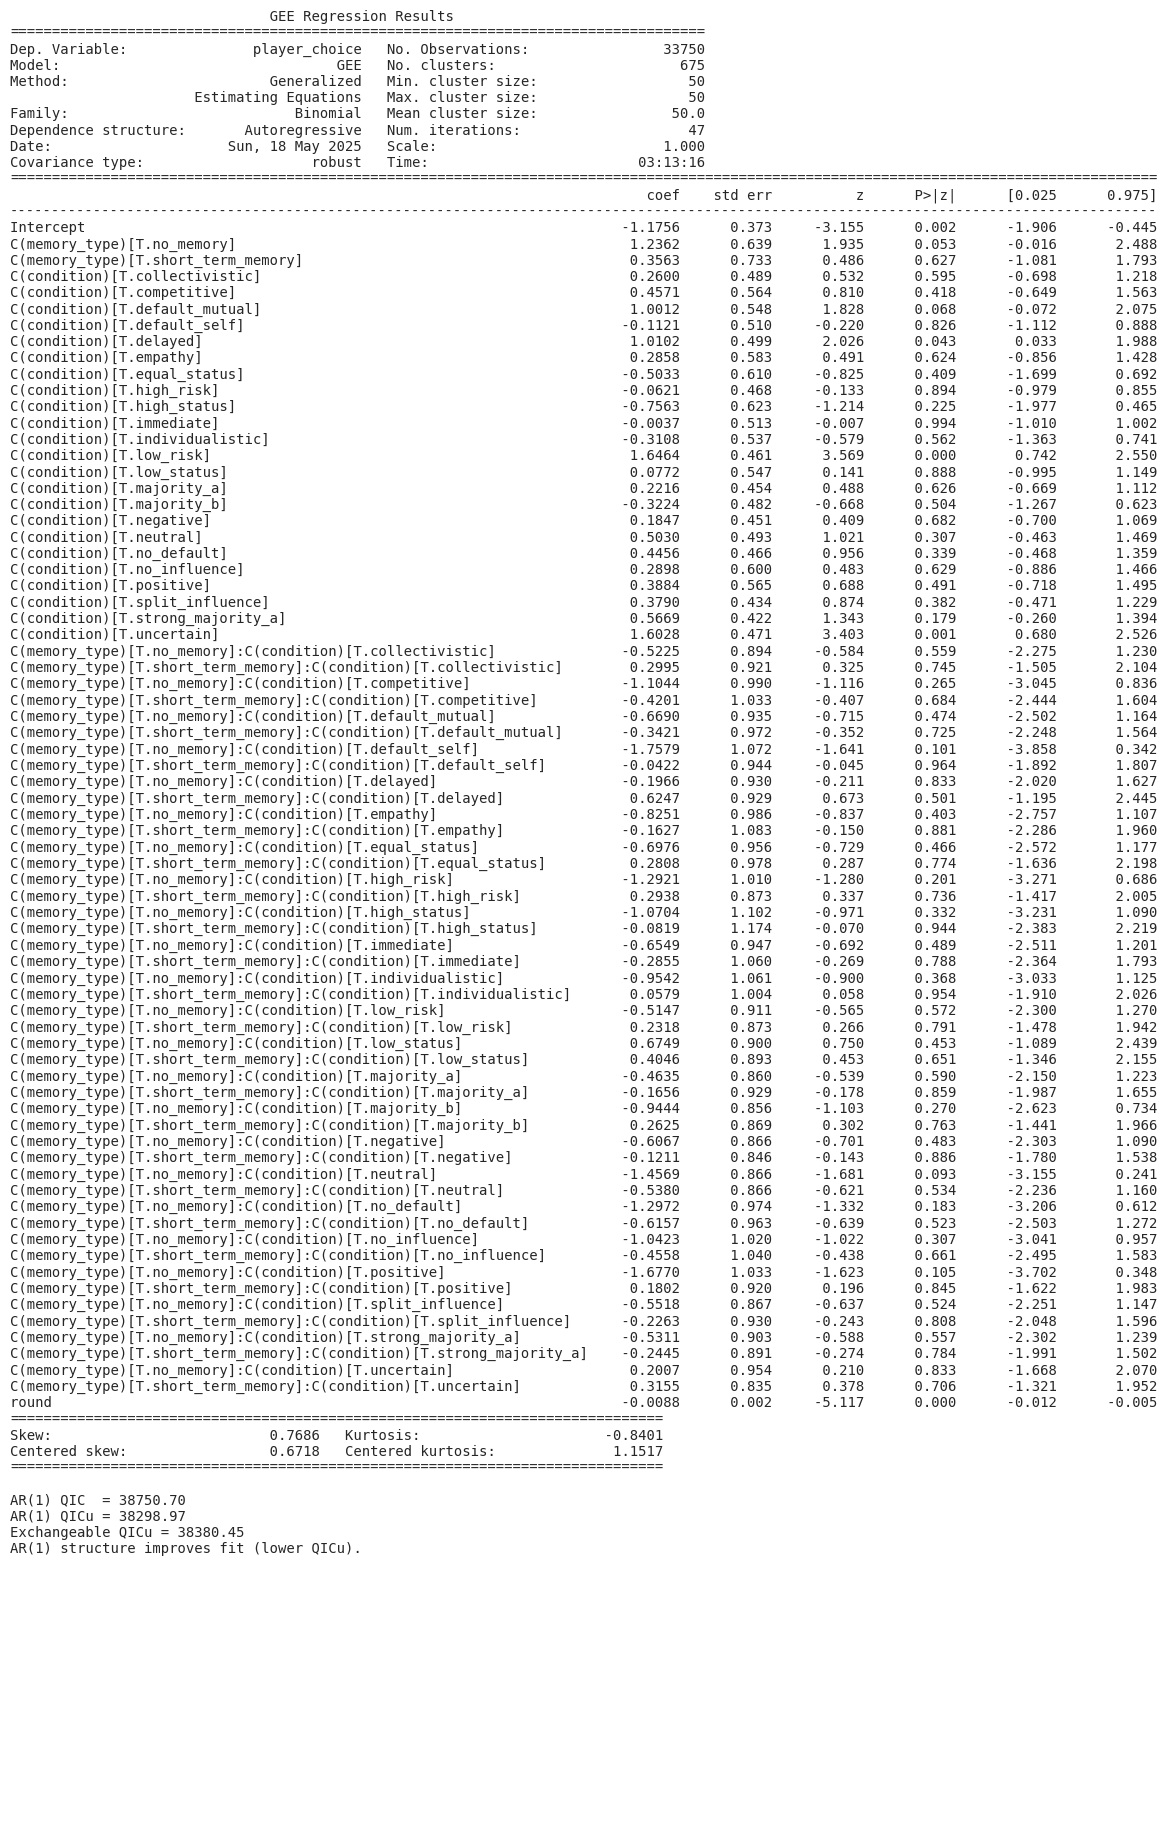

In [121]:
from statsmodels.genmod.generalized_estimating_equations import GEE
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.cov_struct import Autoregressive
import numpy as np

# 1) Fit GEE with AR(1) working correlation
res_gee_ar1 = GEE.from_formula(
    formula    = formula2,       # same full‐interaction formula you used
    groups     = "exp_id",
    data       = df,
    family     = Binomial(),
    cov_struct = Autoregressive()   # AR(1) instead of Exchangeable
).fit()

# 2) Print the key summary
print(res_gee_ar1.summary())

# 3) Compute QIC & QICu (unpacked as a tuple)
try:
    qic_ar1, qicu_ar1 = res_gee_ar1.qic()
    print(f"AR(1) QIC  = {qic_ar1:.2f}")
    print(f"AR(1) QICu = {qicu_ar1:.2f}")
except AttributeError:
    print("No .qic() on this version of statsmodels; please upgrade to get built-in QIC/QICu.")

# 4) Compare with exchangeable:
#    (Exchangeable QICu was e.g. 38380.45)
print("\nComparison of QICu:")
print(f"  Exchangeable QICu = {qicu_value:.2f}")
print(f"       AR(1) QICu = {qicu_ar1:.2f}")

if qicu_ar1 < qicu_value:
    print("AR(1) structure improves fit (lower QICu).")
else:
    print("Exchangeable structure remains preferable (lower QICu).")

# 5) Dump full summary + QIC outputs as a single PNG
import matplotlib.pyplot as plt

# Gather text
output_lines = []
output_lines.append(res_gee_ar1.summary().as_text())
try:
    output_lines.append(f"\nAR(1) QIC  = {qic_ar1:.2f}")
    output_lines.append(f"AR(1) QICu = {qicu_ar1:.2f}")
    output_lines.append(f"Exchangeable QICu = {qicu_value:.2f}")
    if qicu_ar1 < qicu_value:
        output_lines.append("AR(1) structure improves fit (lower QICu).")
    else:
        output_lines.append("Exchangeable structure remains preferable (lower QICu).")
except NameError:
    output_lines.append("\nQIC/QICu not computed.")

output_str = "\n".join(output_lines)
lines = output_str.split("\n")
fig, ax = plt.subplots(figsize=(10, max(6, len(lines) * 0.25)))
ax.axis('off')
ax.text(
    0, 1,
    output_str,
    family='monospace',
    fontsize=10,
    va='top',
)
fig.savefig("res_gee_ar1_summary.png", bbox_inches='tight', dpi=300)


R[write to console]: NOTE: 174 fixed-effects (8,700 observations) removed because of only 0 (or only 1) outcomes.

R[write to console]: The variables 'memory_typeno_memory', 'memory_typeshort_term_memory', 'conditioncollectivistic', 'conditioncompetitive', 'conditiondefault_mutual', 'conditiondefault_self' and 65 others have been removed because of collinearity (see $collin.var).



=== FE-Logit  (fixest::feglm, SE clustered by model) ===
+-------+---------+------------+---------+---------+
|       |   Coef. |   Std.Err. |       z |   P>|z| |
+=======+=========+============+=========+=========+
| round | -0.0137 |     0.0055 | -2.4970 |  0.0125 |
+-------+---------+------------+---------+---------+
=== RE-/Pooled Logit  (fixest::feglm, SE clustered by model) ===
+---------------------------------------------------------+---------+------------+---------+---------+
|                                                         |   Coef. |   Std.Err. |       z |   P>|z| |
+=========================================================+=========+============+=========+=========+
| (Intercept)                                             | -1.2680 |     0.4243 | -2.9884 |  0.0028 |
+---------------------------------------------------------+---------+------------+---------+---------+
| memory_typeno_memory                                    |  1.4342 |     0.4739 |  3.0264 |  0.00

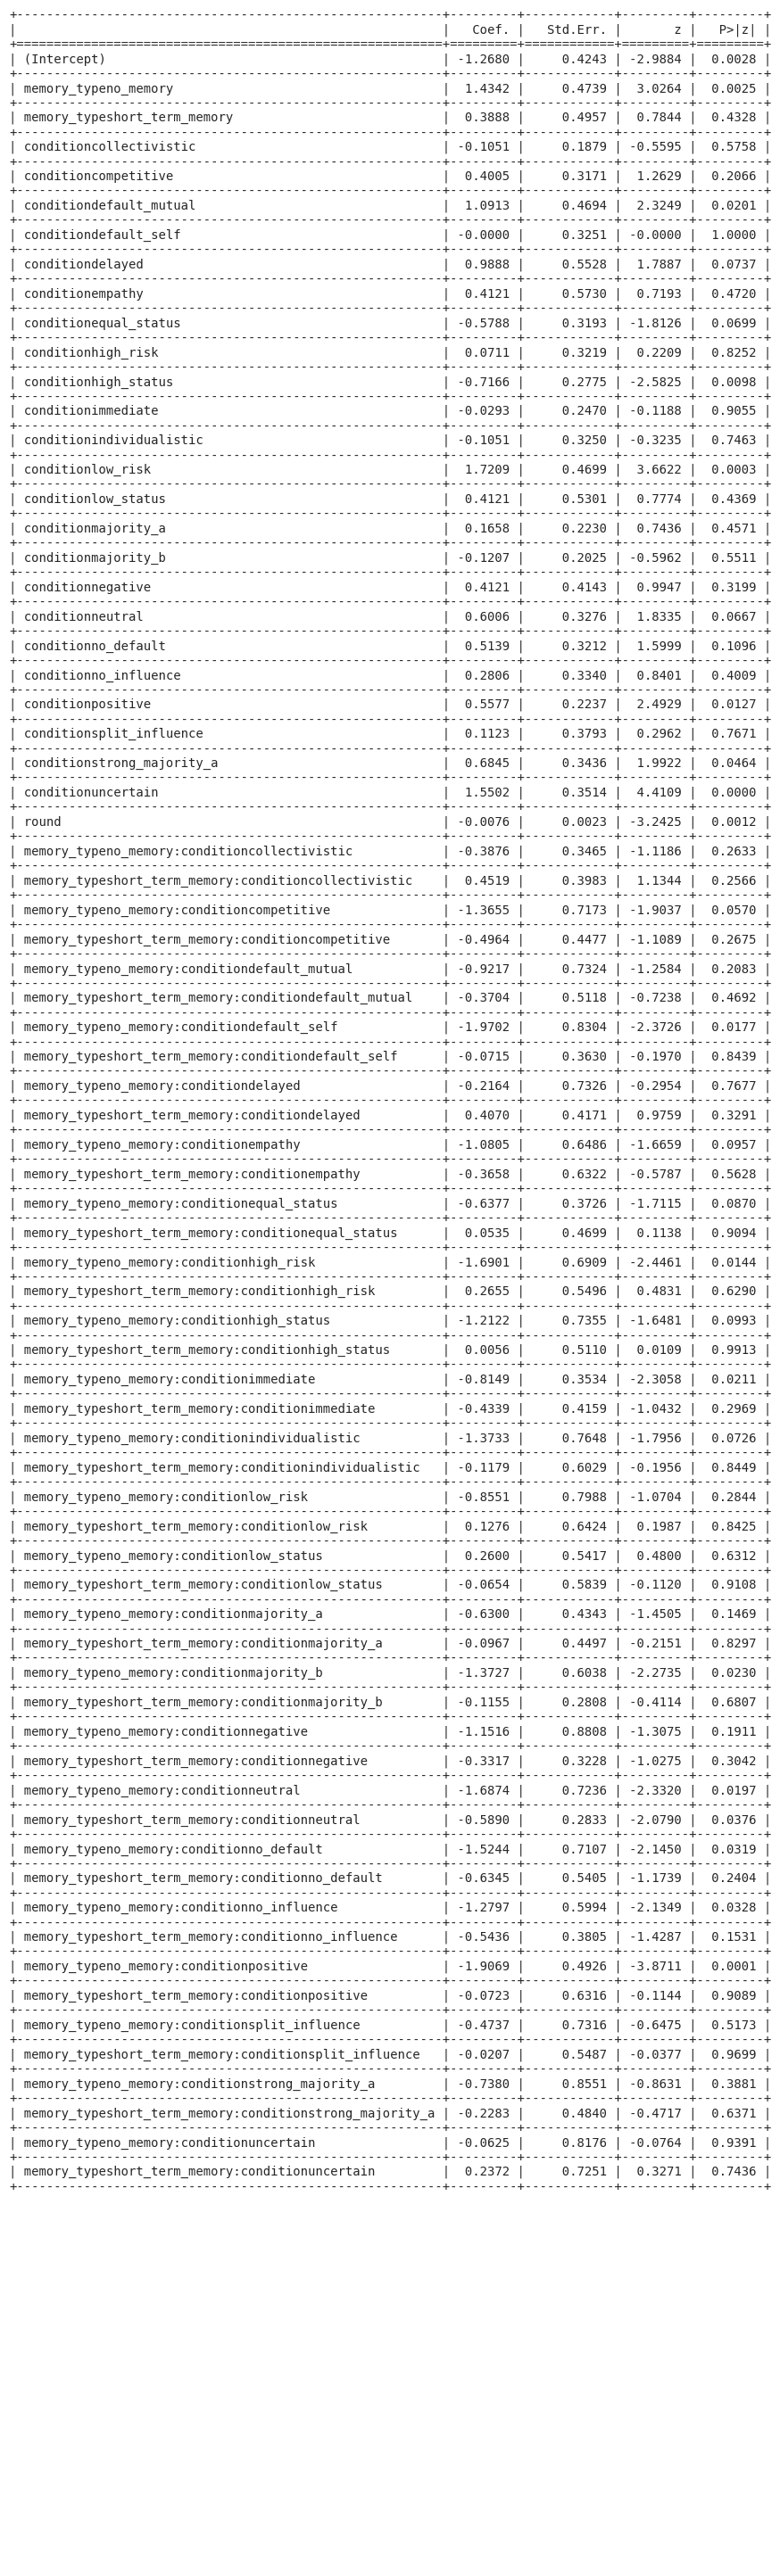

In [122]:
# Panel-logit with R’s **fixest**: both FE and RE specifications

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from tabulate import tabulate  # <-- only addition
pandas2ri.activate()               # enable automatic DataFrame conversion

# -----------------------------------------------------
# 1) Push the Python DataFrame into R
ro.globalenv["rdf"] = pandas2ri.py2rpy(df)

# -----------------------------------------------------
# 2) Ensure fixest is installed and loaded
ro.r("""
if (!requireNamespace("fixest", quietly = TRUE)) {
  install.packages("fixest", repos = "https://cloud.r-project.org")
}
library(fixest)        # provides feglm()
""")

# -----------------------------------------------------
# 3-A)  FIXED-effects logit  (exp_id FE, SEs clustered by model)
ro.r("""
res_fe <- feglm(
  player_choice ~ memory_type * condition + round | exp_id ,   # FE on exp_id
  data    = rdf,
  family  = binomial("logit"),
  cluster = ~model
)
coef_fe <- as.data.frame(coeftable(res_fe))
""")
coef_fe = pandas2ri.rpy2py(ro.r("coef_fe"))
coef_fe.columns = ["Coef.", "Std.Err.", "z", "P>|z|"]

# Dump FE table to Excel
coef_fe.to_excel("coef_fe.xlsx", index=True)

print("=== FE-Logit  (fixest::feglm, SE clustered by model) ===")
print(tabulate(coef_fe, headers="keys", floatfmt=".4f", tablefmt="grid"))

# Dump FE table as PNG
fe_text = tabulate(coef_fe, headers="keys", floatfmt=".4f", tablefmt="grid")
lines = fe_text.split("\n")
fig, ax = plt.subplots(figsize=(8, max(6, len(lines) * 0.25)))
ax.axis('off')
ax.text(0, 1, fe_text, family='monospace', fontsize=10, va='top')
fig.savefig("coef_fe.png", bbox_inches='tight', dpi=300)


# -----------------------------------------------------
# 3-B)  RANDOM-effects / pooled logit  (no FE, SEs clustered by model)
ro.r("""
res_re <- feglm(
  player_choice ~ memory_type * condition + round | 0 ,   # no FE ⇒ RE
  data    = rdf,
  family  = binomial("logit"),
  cluster = ~model
)
coef_re <- as.data.frame(coeftable(res_re))
""")
coef_re = pandas2ri.rpy2py(ro.r("coef_re"))
coef_re.columns = ["Coef.", "Std.Err.", "z", "P>|z|"]

# Dump RE table to Excel
coef_re.to_excel("coef_re.xlsx", index=True)

print("=== RE-/Pooled Logit  (fixest::feglm, SE clustered by model) ===")
print(tabulate(coef_re, headers="keys", floatfmt=".4f", tablefmt="grid"))

# Dump RE table as PNG
re_text = tabulate(coef_re, headers="keys", floatfmt=".4f", tablefmt="grid")
lines = re_text.split("\n")
fig, ax = plt.subplots(figsize=(8, max(6, len(lines) * 0.25)))
ax.axis('off')
ax.text(0, 1, re_text, family='monospace', fontsize=10, va='top')
fig.savefig("coef_re.png", bbox_inches='tight', dpi=300)


In [36]:
# Poisson‐GLM for pay‐off counts

pois = smf.glm(
    formula = "player_score ~ C(memory_type)*C(condition) + round",
    data    = df,
    family  = sm.families.Poisson()
).fit(
    cov_type = 'cluster',
    cov_kwds = {'groups': df['model'], 'ddof':1}
)

print(pois.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:           player_score   No. Observations:                33750
Model:                            GLM   Df Residuals:                    33677
Model Family:                 Poisson   Df Model:                           72
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -51677.
Date:                Thu, 15 May 2025   Deviance:                       44618.
Time:                        06:59:33   Pearson chi2:                 5.05e+04
No. Iterations:                     5   Pseudo R-squ. (CS):           0.008530
Covariance Type:              cluster                                         
                                                                            coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------

                 Generalized Linear Model Regression Results                  
Dep. Variable:           player_score   No. Observations:                33750
Model:                            GLM   Df Residuals:                    33677
Model Family:                 Poisson   Df Model:                           72
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -51677.
Date:                Sun, 18 May 2025   Deviance:                       44618.
Time:                        09:53:51   Pearson chi2:                 5.05e+04
No. Iterations:                     5   Pseudo R-squ. (CS):           0.008530
Covariance Type:              cluster                                         
                                                                            coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------

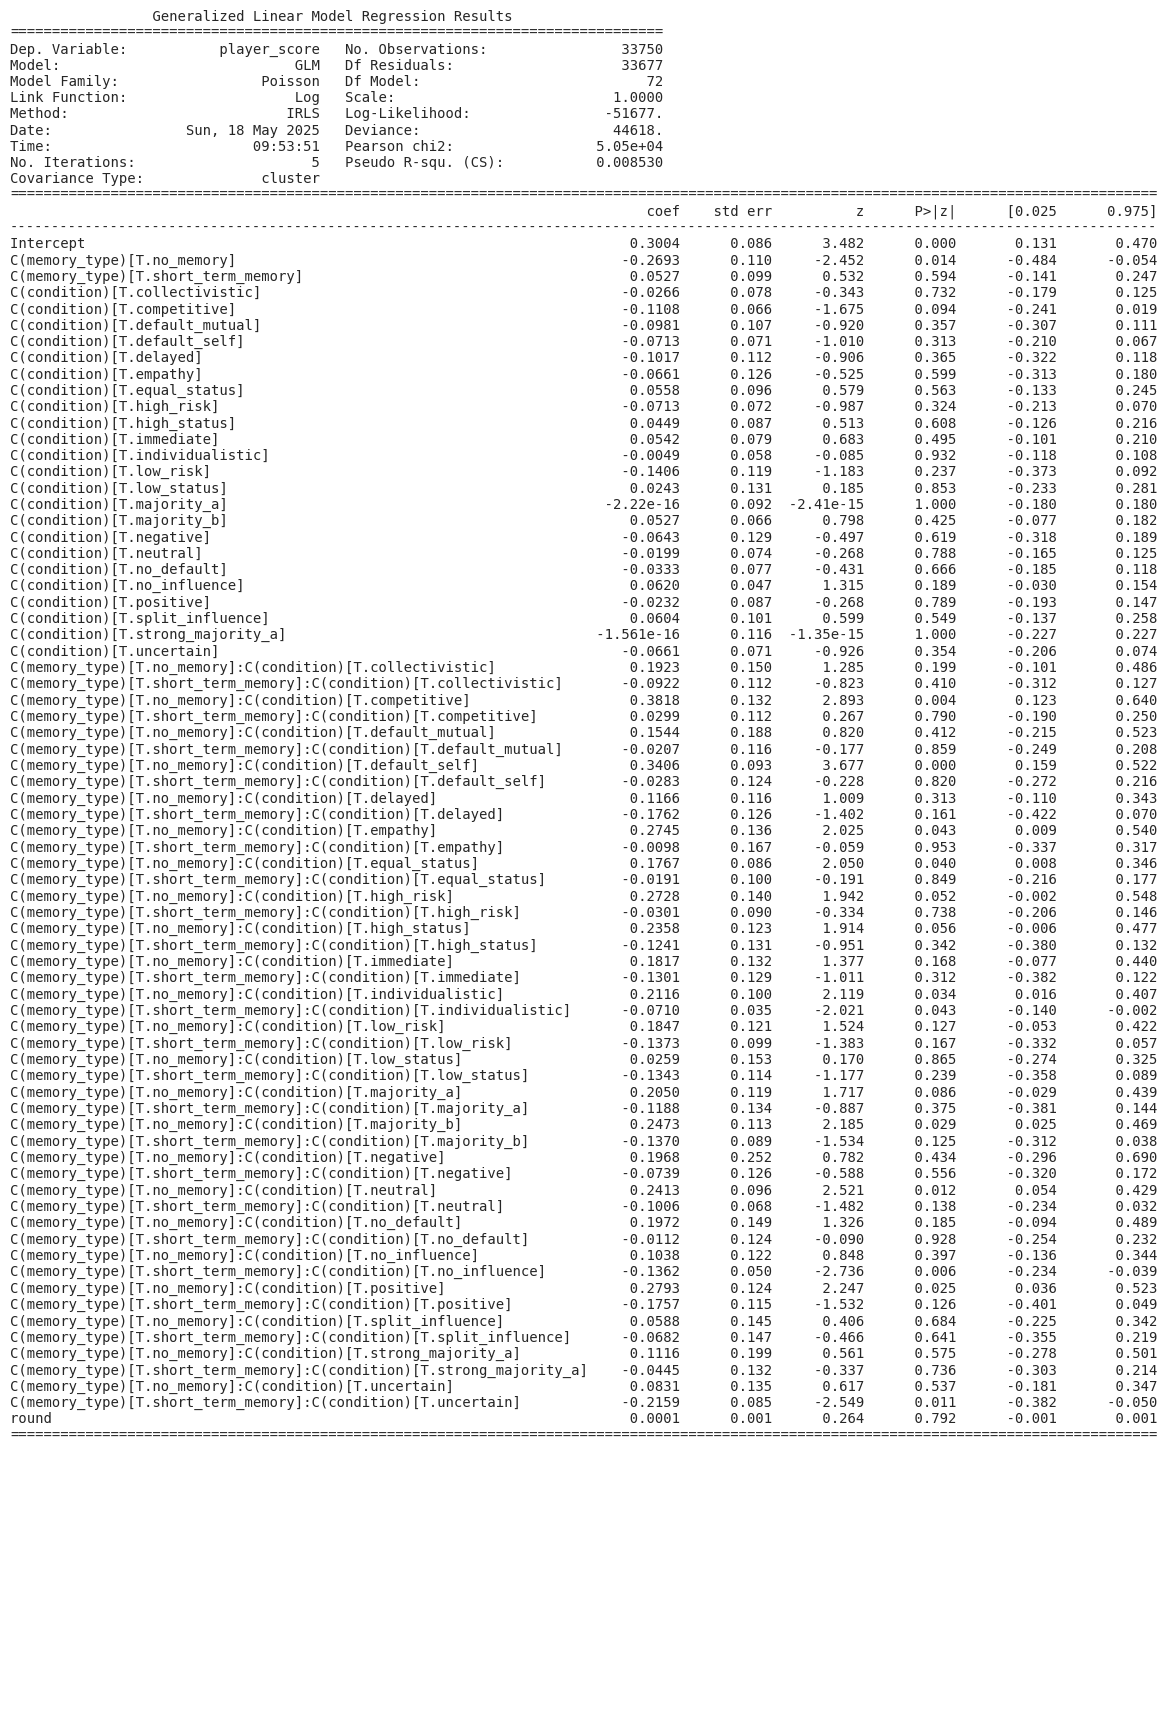

In [123]:
# Poisson‐GLM for pay‐off counts

pois = smf.glm(
    formula = "player_score ~ C(memory_type)*C(condition) + round",
    data    = df,
    family  = sm.families.Poisson()
).fit(
    cov_type = 'cluster',
    cov_kwds = {'groups': df['model'], 'ddof':1}
)

# Print summary to console
print(pois.summary())

# Dump summary to file
with open("pois_glm_summary.txt", "w") as f:
    f.write(pois.summary().as_text())

# Dump the full summary as PNG
summary_str = pois.summary().as_text()
lines = summary_str.split('\n')
fig_height = max(6, len(lines) * 0.25)  # ~0.25" per line, min height 6"
fig, ax = plt.subplots(figsize=(8, fig_height))
ax.axis('off')
ax.text(
    0, 1,
    summary_str,
    family='monospace',
    fontsize=10,
    va='top',
)
fig.savefig("pois_glm_summary.png", bbox_inches='tight', dpi=300)

# Dump coefficients table to Excel
coef_df = pois.summary2().tables[1]
coef_df.to_excel("pois_glm_coefficients.xlsx", index=True)


In [43]:
# Marginal effects on cooperation (GLM Binomial)

# Average partial effects of each regressor on Pr(cooperate)

mfx_glm = glm_bin2.get_margeff(          #  <-- works for any GLMResults
    at     = 'mean',                    # evaluate at sample means
    method = 'dydx',                    # ∂P/∂x  (default for logit)
)
print(mfx_glm.summary())                # dy/dx, SE, z-stat, p-value



         GLM Marginal Effects        
Dep. Variable:          player_choice
Method:                          dydx
At:                              mean
                                                                           dy/dx    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------
C(memory_type)[T.no_memory]                                               0.2978      0.120      2.485      0.013       0.063       0.533
C(memory_type)[T.short_term_memory]                                       0.0808      0.110      0.732      0.464      -0.135       0.297
C(condition)[T.collectivistic]                                           -0.0218      0.040     -0.545      0.586      -0.100       0.057
C(condition)[T.competitive]                                               0.0832      0.062      1.335      0.182      -0.039       0.205
C(condition)[T.defau

         GLM Marginal Effects        
Dep. Variable:          player_choice
Method:                          dydx
At:                              mean
                                                                           dy/dx    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------------------
C(memory_type)[T.no_memory]                                               0.2978      0.120      2.485      0.013       0.063       0.533
C(memory_type)[T.short_term_memory]                                       0.0808      0.110      0.732      0.464      -0.135       0.297
C(condition)[T.collectivistic]                                           -0.0218      0.040     -0.545      0.586      -0.100       0.057
C(condition)[T.competitive]                                               0.0832      0.062      1.335      0.182      -0.039       0.205
C(condition)[T.defau

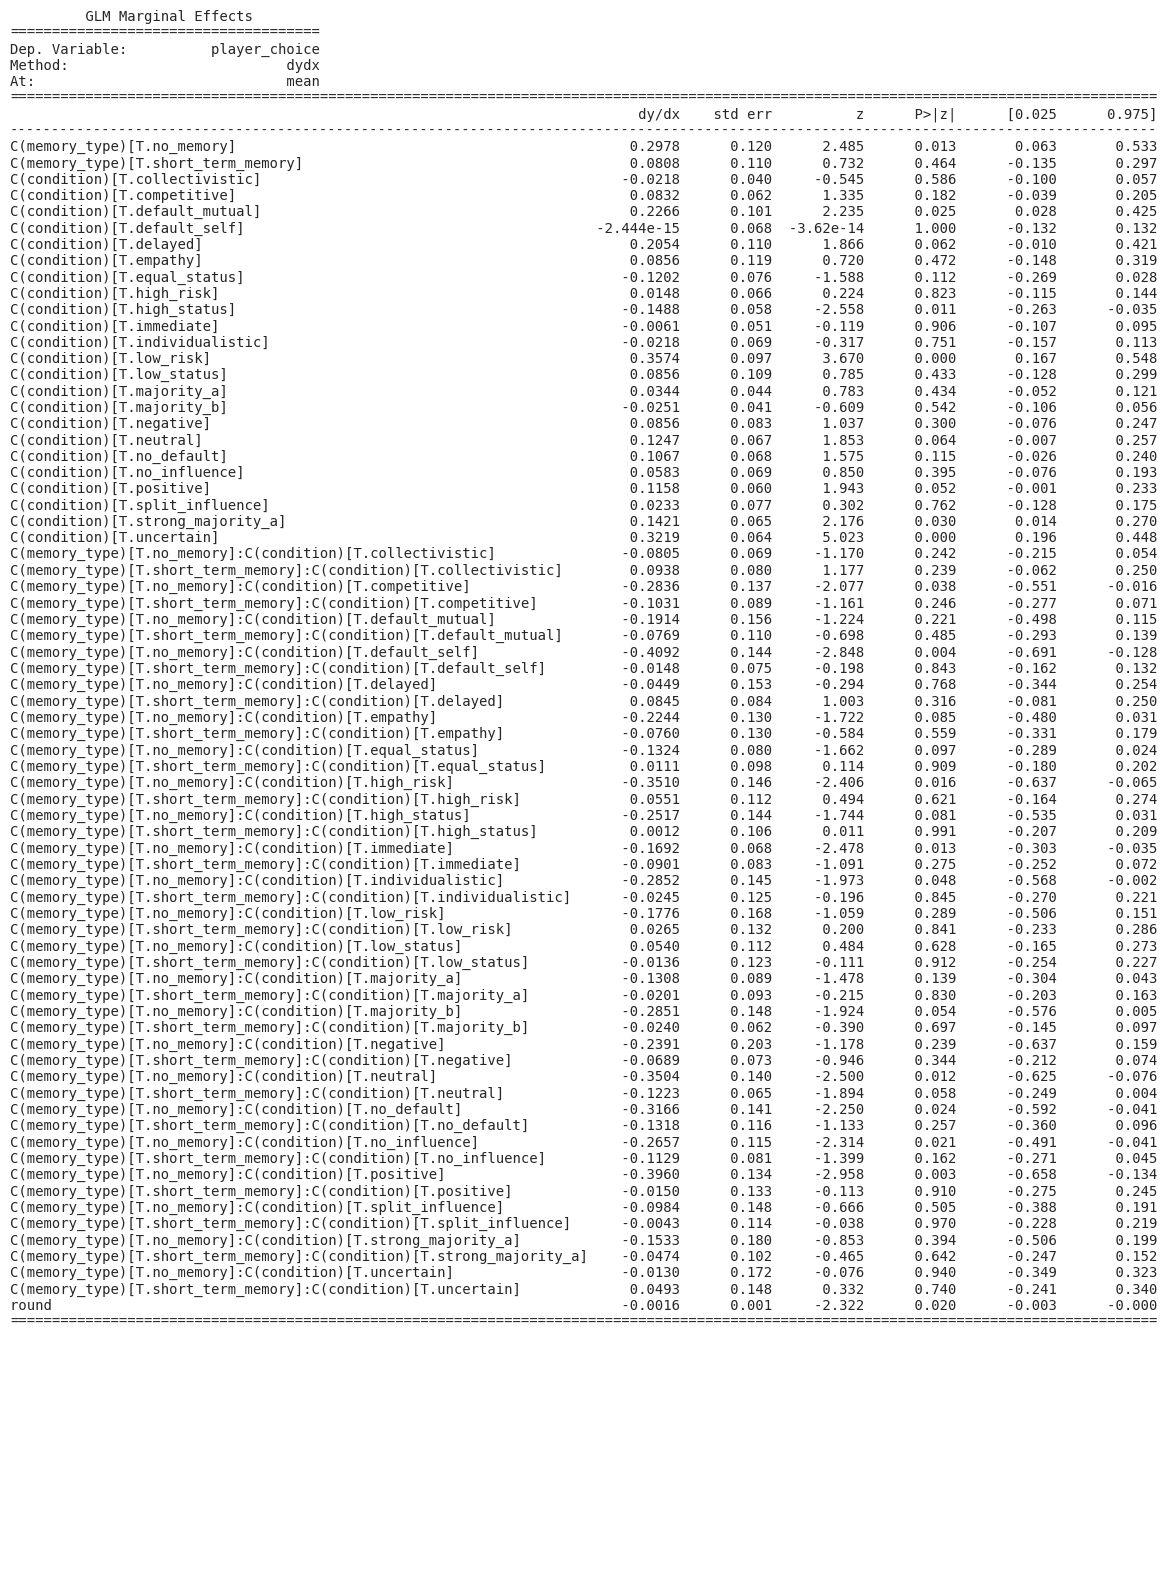

In [85]:
# Marginal effects on cooperation (GLM Binomial)
# Average partial effects of each regressor on Pr(cooperate)

mfx_glm = glm_bin2.get_margeff(          #  <-- works for any GLMResults
    at     = 'mean',                    # evaluate at sample means
    method = 'dydx',                    # ∂P/∂x  (default for logit)
)
print(mfx_glm.summary())                # dy/dx, SE, z-stat, p-value

# Dump marginal effects summary to file
with open("mfx_glm_summary.txt", "w") as f:
    f.write(mfx_glm.summary().as_text())

# Dump the full summary as PNG
summary_str = mfx_glm.summary().as_text()
lines = summary_str.split('\n')
fig_height = max(6, len(lines) * 0.25)  # ~0.25" per line, min height 6"
fig, ax = plt.subplots(figsize=(8, fig_height))
ax.axis('off')
ax.text(
    0, 1,
    summary_str,
    family='monospace',
    fontsize=10,
    va='top',
)
fig.savefig("mfx_glm_summary.png", bbox_inches='tight', dpi=300)


### Diagnostic Tests

- glm_bin2 (cluster-robust Binomial GLM)

- logit_fit (optional clustered Logit)

- pois (cluster-robust Poisson)

In [87]:
# Test imports
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats import diagnostic as smd
from statsmodels.stats.sandwich_covariance import cov_cluster
from statsmodels.graphics.gofplots import qqplot
import matplotlib.pyplot as plt


In [88]:
# Variance-inflation factors (multicollinearity)
# Design matrix used by glm_bin2 (already has intercept dummy-coded)
exog = glm_bin2.model.exog
names = glm_bin2.model.exog_names

vif = pd.Series(
    [variance_inflation_factor(exog, i) for i in range(exog.shape[1])],
    index = names
).round(2)

print("VIF summary")
display(vif.describe())   # min / mean / max


VIF summary


count    73.000
mean      6.387
std       9.790
min       1.000
25%       3.950
50%       3.950
75%       5.760
max      78.120
dtype: float64

In [91]:
bad = (
    pd.Series(
        {name: variance_inflation_factor(exog, i)
         for i, name in enumerate(names)})
    .sort_values(ascending=False)
)
print("VIFs:")
display(bad)

# Dump VIFs to PNG
vif_text = bad.to_string()
lines = vif_text.split('\n')
fig, ax = plt.subplots(figsize=(8, max(6, len(lines) * 0.25)))
ax.axis('off')
ax.text(
    0, 1,
    "VIFs:\n" + vif_text,
    family='monospace',
    fontsize=10,
    va='top'
)
fig.savefig("vif_summary.png", bbox_inches='tight', dpi=300)


VIFs:


Intercept                                                         78.122
C(memory_type)[T.short_term_memory]                               33.333
C(memory_type)[T.no_memory]                                       33.333
C(condition)[T.neutral]                                            8.280
C(memory_type)[T.no_memory]:C(condition)[T.neutral]                5.840
                                                                   ...  
C(memory_type)[T.short_term_memory]:C(condition)[T.majority_b]     3.947
C(memory_type)[T.no_memory]:C(condition)[T.majority_b]             3.947
C(memory_type)[T.no_memory]:C(condition)[T.majority_a]             3.947
C(memory_type)[T.no_memory]:C(condition)[T.high_status]            3.947
round                                                              1.000
Length: 73, dtype: float64

                 Generalized Linear Model Regression Results                  
Dep. Variable:          player_choice   No. Observations:                33750
Model:                            GLM   Df Residuals:                    33723
Model Family:                Binomial   Df Model:                           26
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -19290.
Date:                Sat, 17 May 2025   Deviance:                       38581.
Time:                        20:59:33   Pearson chi2:                 3.38e+04
No. Iterations:                     5   Pseudo R-squ. (CS):            0.09020
Covariance Type:              cluster                                         
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

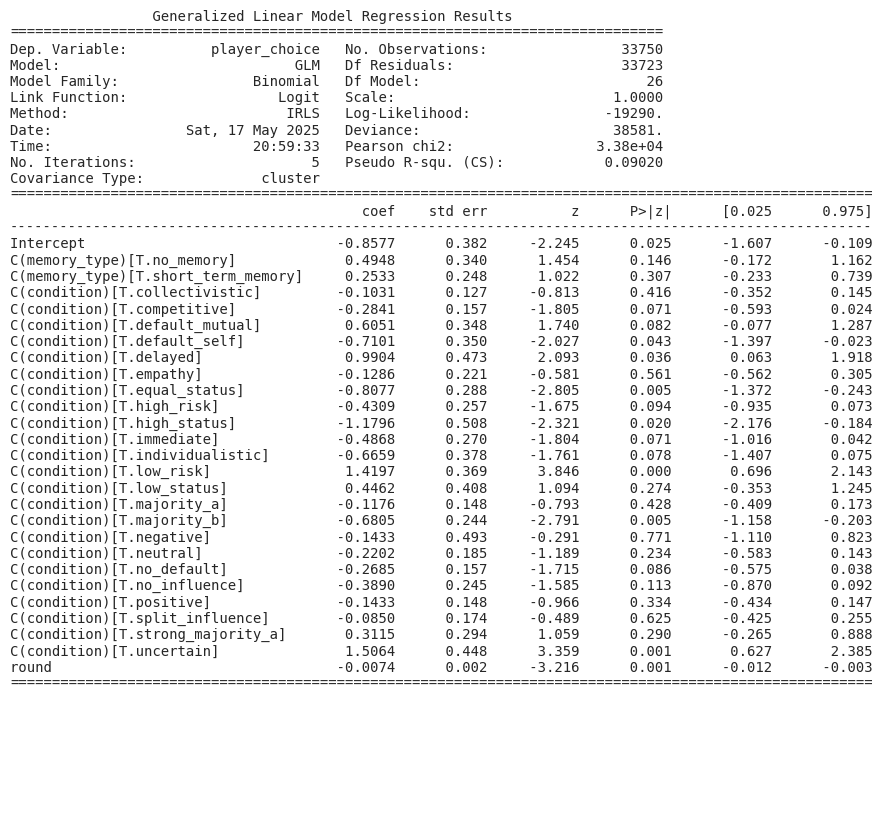

In [96]:
# 1. Re-specify formula without the problematic interaction cells
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

formula_thin = "player_choice ~ C(memory_type) + C(condition) + round"

glm_thin = smf.glm(
    formula = formula_thin,
    data    = df,
    family  = sm.families.Binomial()
).fit(
    cov_type = 'cluster',
    cov_kwds = {'groups': df['model'], 'ddof':1}
)

print(glm_thin.summary())

# Dump summary to file
with open("glm_thin_summary.txt", "w") as f:
    f.write(glm_thin.summary().as_text())

# Dump the full summary as PNG
summary_str = glm_thin.summary().as_text()
lines = summary_str.split('\n')
fig_height = max(6, len(lines) * 0.25)  # ~0.25" per line, min height 6"
fig, ax = plt.subplots(figsize=(8, fig_height))
ax.axis('off')
ax.text(
    0, 1,
    summary_str,
    family='monospace',
    fontsize=10,
    va='top',
)
fig.savefig("glm_thin_summary.png", bbox_inches='tight', dpi=300)


In [93]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
exog   = glm_thin.model.exog
names  = glm_thin.model.exog_names
vif = pd.Series(
        [variance_inflation_factor(exog, i) for i in range(exog.shape[1])],
        index=names).round(2)
print("Max VIF =", vif.max())


Max VIF = 30.12


In [94]:
# Variance-inflation factors (multicollinearity)

exog = glm_thin.model.exog
names = glm_thin.model.exog_names

vif = pd.Series(
    [variance_inflation_factor(exog, i) for i in range(exog.shape[1])],
    index = names
).round(2)

print("VIF summary")
display(vif.describe())   # min / mean / max


VIF summary


count    27.000
mean      2.918
std       5.444
min       1.000
25%       1.920
50%       1.920
75%       1.920
max      30.120
dtype: float64

In [95]:
# Which term has VIF > 10?
high = vif[vif > 10].sort_values(ascending=False)
print(high)


Intercept    30.12
dtype: float64


In [56]:
# Marginal effects on cooperation (GLM Binomial)

# Average partial effects of each regressor on Pr(cooperate)

mfx_glm = glm_thin.get_margeff(          #  <-- works for any GLMResults
    at     = 'mean',                    # evaluate at sample means
    method = 'dydx',                    # ∂P/∂x  (default for logit)
)
print(mfx_glm.summary())                # dy/dx, SE, z-stat, p-value



         GLM Marginal Effects        
Dep. Variable:          player_choice
Method:                          dydx
At:                              mean
                                         dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
C(memory_type)[T.no_memory]             0.1030      0.078      1.316      0.188      -0.050       0.256
C(memory_type)[T.short_term_memory]     0.0527      0.057      0.921      0.357      -0.059       0.165
C(condition)[T.collectivistic]         -0.0215      0.027     -0.795      0.427      -0.074       0.031
C(condition)[T.competitive]            -0.0591      0.031     -1.923      0.054      -0.119       0.001
C(condition)[T.default_mutual]          0.1260      0.071      1.762      0.078      -0.014       0.266
C(condition)[T.default_self]           -0.1478      0.073     -2.026      0.043      -0.291      -0.005
C(condition)[T.d

In [97]:
# Average partial effects of each regressor on Pr(cooperate)

mfx_glm = glm_thin.get_margeff(          #  <-- works for any GLMResults
    at     = 'mean',                    # evaluate at sample means
    method = 'dydx',                    # ∂P/∂x  (default for logit)
)
print(mfx_glm.summary())                # dy/dx, SE, z-stat, p-value

# Dump marginal effects summary to file
with open("mfx_glm__thin_summary.txt", "w") as f:
    f.write(mfx_glm.summary().as_text())

# Dump the full summary as PNG
summary_str = mfx_glm.summary().as_text()
lines = summary_str.split('\n')
fig_height = max(6, len(lines) * 0.25)  # ~0.25" per line, min height 6"
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, fig_height))
ax.axis('off')
ax.text(
    0, 1,
    summary_str,
    family='monospace',
    fontsize=10,
    va='top',
)
fig.savefig("mfx_glm_thin_summary.png", bbox_inches='tight', dpi=300)


         GLM Marginal Effects        
Dep. Variable:          player_choice
Method:                          dydx
At:                              mean
                                         dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
C(memory_type)[T.no_memory]             0.1030      0.078      1.316      0.188      -0.050       0.256
C(memory_type)[T.short_term_memory]     0.0527      0.057      0.921      0.357      -0.059       0.165
C(condition)[T.collectivistic]         -0.0215      0.027     -0.795      0.427      -0.074       0.031
C(condition)[T.competitive]            -0.0591      0.031     -1.923      0.054      -0.119       0.001
C(condition)[T.default_mutual]          0.1260      0.071      1.762      0.078      -0.014       0.266
C(condition)[T.default_self]           -0.1478      0.073     -2.026      0.043      -0.291      -0.005
C(condition)[T.d

Poisson Pearson χ² / df = 1.50
→ Consider Negative Binomial (over-dispersed).



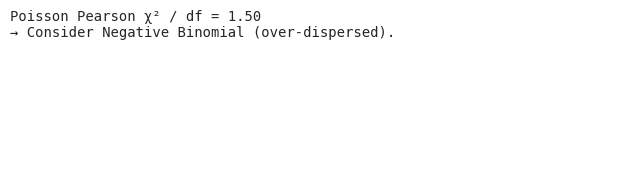

In [98]:
# Over-dispersion check for the Poisson pay-off model

pearson_overdisp = pois.pearson_chi2 / pois.df_resid
output_str = f"Poisson Pearson χ² / df = {pearson_overdisp:0.2f}\n"
if pearson_overdisp > 1.5:
    output_str += "→ Consider Negative Binomial (over-dispersed).\n"
print(output_str)

# Dump over-dispersion check output as PNG
import matplotlib.pyplot as plt

lines = output_str.split('\n')
fig, ax = plt.subplots(figsize=(8, max(2, len(lines) * 0.5)))
ax.axis('off')
ax.text(
    0, 1,
    output_str,
    family='monospace',
    fontsize=10,
    va='top',
)
fig.savefig("pois_overdispersion_check.png", bbox_inches='tight', dpi=300)


                 Generalized Linear Model Regression Results                  
Dep. Variable:           player_score   No. Observations:                33750
Model:                            GLM   Df Residuals:                    33723
Model Family:        NegativeBinomial   Df Model:                           26
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -52727.
Date:                Sat, 17 May 2025   Deviance:                       21347.
Time:                        21:18:02   Pearson chi2:                 2.23e+04
No. Iterations:                     6   Pseudo R-squ. (CS):           0.002487
Covariance Type:              cluster                                         
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
In

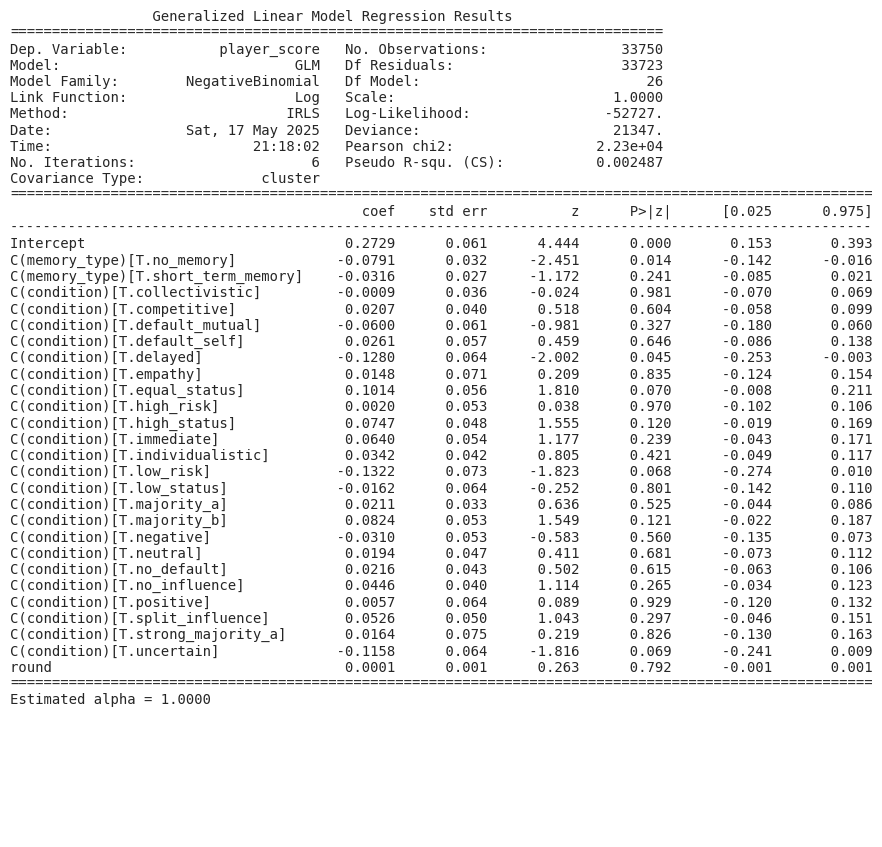

In [99]:
# 1. estimates α

nb_glm = smf.glm(
    formula = "player_score ~ C(memory_type) + C(condition) + round",
    data    = df,
    family  = sm.families.NegativeBinomial(alpha=1.0)   # start value
).fit(
    cov_type = 'cluster',
    cov_kwds = {'groups': df['model'], 'ddof':1}
)

# Print summary and estimated alpha
print(nb_glm.summary())
print("Estimated alpha =", nb_glm.scale)

# Dump summary to file
with open("nb_glm_summary.txt", "w") as f:
    f.write(nb_glm.summary().as_text())

# Dump summary + estimated alpha as PNG
summary_str = nb_glm.summary().as_text()
output_str = summary_str + f"\nEstimated alpha = {nb_glm.scale:.4f}"

import matplotlib.pyplot as plt

lines = output_str.split('\n')
fig_height = max(6, len(lines) * 0.25)  # ~0.25" per line, min height 6"
fig, ax = plt.subplots(figsize=(8, fig_height))
ax.axis('off')
ax.text(
    0, 1,
    output_str,
    family='monospace',
    fontsize=10,
    va='top',
)
fig.savefig("nb_glm_summary.png", bbox_inches='tight', dpi=300)


In [101]:
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

nb_mod = smf.negativebinomial(
    formula = "player_score ~ C(memory_type) + C(condition) + round",
    data    = df
).fit(
    cov_type = 'cluster',
    cov_kwds = {'groups': df['model'], 'ddof':1},
    disp     = 0                # silent
)

# Print summary and estimated alpha
print(nb_mod.summary())
print("Estimated alpha =", nb_mod.params['alpha'])   # by label

# Dump summary to file
with open("nb_mod_summary.txt", "w") as f:
    f.write(nb_mod.summary().as_text())

# Dump the full summary + alpha as PNG
summary_str = nb_mod.summary().as_text()
output_str = summary_str + f"\nEstimated alpha = {nb_mod.params['alpha']:.4f}"
lines = output_str.split('\n')
fig_height = max(6, len(lines) * 0.25)  # ~0.25" per line, min height 6"
fig, ax = plt.subplots(figsize=(8, fig_height))
ax.axis('off')
ax.text(
    0, 1,
    output_str,
    family='monospace',
    fontsize=10,
    va='top',
)
fig.savefig("nb_mod_summary.png", bbox_inches='tight', dpi=300)


                     NegativeBinomial Regression Results                      
Dep. Variable:           player_score   No. Observations:                33750
Model:               NegativeBinomial   Df Residuals:                    33723
Method:                           MLE   Df Model:                           26
Date:                Sat, 17 May 2025   Pseudo R-squ.:                0.001386
Time:                        21:18:58   Log-Likelihood:                -50634.
converged:                       True   LL-Null:                       -50705.
Covariance Type:              cluster   LLR p-value:                 1.098e-17
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               0.2740      0.062      4.436      0.000       0.153       0.395
C(memory_type)[T.no_memory]            -0.0788      0.03

In [102]:
print(f"Poisson   AIC = {pois.aic:,.1f}")
print(f"NegBin    AIC = {nb_mod.aic:,.1f}")
alpha_est = nb_mod.params['alpha']
print(f"Estimated alpha = {alpha_est:.3f}")

# Dump AIC comparison and alpha estimate as PNG
import matplotlib.pyplot as plt

output_str = (
    f"Poisson   AIC = {pois.aic:,.1f}\n"
    f"NegBin    AIC = {nb_mod.aic:,.1f}\n"
    f"Estimated alpha = {alpha_est:.3f}"
)
lines = output_str.split('\n')
fig, ax = plt.subplots(figsize=(8, max(2, len(lines) * 0.5)))
ax.axis('off')
ax.text(
    0, 1,
    output_str,
    family='monospace',
    fontsize=10,
    va='top',
)
fig.savefig("model_aic_alpha.png", bbox_inches='tight', dpi=300)


Poisson   AIC = 103,500.4
NegBin    AIC = 101,325.0
Estimated alpha = 0.275


BG (glm_full)  χ²(4) = 12107.82,  p = 0.000
BG (glm_thin)  χ²(4) = 12407.43,  p = 0.000


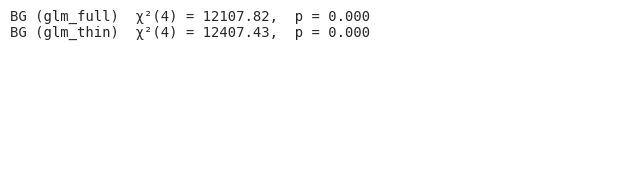

In [103]:
# Serial correlation (Breusch–Godfrey) on GLM residuals

from statsmodels.stats import diagnostic as smd
import numpy as np
import matplotlib.pyplot as plt

def bg_for_glm(results, nlags=4):
    # give the GLMResults a .resid attribute that BG expects
    if not hasattr(results, "resid"):
        results.resid = results.resid_response
    bg = smd.acorr_breusch_godfrey(results, nlags=nlags, store=False)
    # bg returns (stat, p-value, _, _)
    return bg[0], bg[1]

# Perform BG test on glm_bin2
bg_stat_full, bg_p_full = bg_for_glm(glm_bin2, nlags=4)
output_full = f"BG (glm_full)  χ²(4) = {bg_stat_full:0.2f},  p = {bg_p_full:0.3f}"
print(output_full)

# Perform BG test on glm_thin
bg_stat_thin, bg_p_thin = bg_for_glm(glm_thin, nlags=4)
output_thin = f"BG (glm_thin)  χ²(4) = {bg_stat_thin:0.2f},  p = {bg_p_thin:0.3f}"
print(output_thin)

# Dump BG outputs as PNG
combined_output = output_full + "\n" + output_thin
lines = combined_output.split('\n')
fig, ax = plt.subplots(figsize=(8, max(2, len(lines) * 0.5)))
ax.axis('off')
ax.text(
    0, 1,
    combined_output,
    family='monospace',
    fontsize=10,
    va='top',
)
fig.savefig("bg_serial_correlation.png", bbox_inches='tight', dpi=300)


In [104]:
# Average AR(1) within each game
resid = glm_thin.resid_response
df['_resid'] = resid

ar1 = (
    df.sort_values(['exp_id', 'round'])
      .groupby('exp_id')['_resid']
      .apply(lambda x: x.autocorr(lag=1))
      .mean()
)
output_str = f"Mean AR(1) of residuals within games = {ar1:0.3f}"
print(output_str)

# Dump AR(1) output as PNG
import matplotlib.pyplot as plt

lines = output_str.split('\n')
fig, ax = plt.subplots(figsize=(8, max(2, len(lines) * 0.5)))
ax.axis('off')
ax.text(
    0, 1,
    output_str,
    family='monospace',
    fontsize=10,
    va='top',
)
fig.savefig("ar1_residuals.png", bbox_inches='tight', dpi=300)


Mean AR(1) of residuals within games = 0.283


In [105]:
from statsmodels.genmod.generalized_estimating_equations import GEE
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.cov_struct import Independence, Exchangeable
import matplotlib.pyplot as plt

# Fit GEE models with different correlation structures
gee_ind = GEE.from_formula(
    "player_choice ~ C(memory_type) + C(condition) + round",
    groups = "exp_id",
    data   = df,
    family = Binomial(), cov_struct = Independence()
).fit()

gee_exc = GEE.from_formula(
    "player_choice ~ C(memory_type) + C(condition) + round",
    groups = "exp_id",
    data   = df,
    family = Binomial(), cov_struct = Exchangeable()
).fit()

# Print key coefficient for no-memory
print("Key coef – no-memory")
print("Clustered GLM :", glm_thin.params['C(memory_type)[T.no_memory]'])
print("GEE Indep     :", gee_ind.params['C(memory_type)[T.no_memory]'])
print("GEE Exch      :", gee_exc.params['C(memory_type)[T.no_memory]'])

# Dump the printed output as PNG
output_str = (
    "Key coef – no-memory\n"
    f"Clustered GLM : {glm_thin.params['C(memory_type)[T.no_memory]']:.4f}\n"
    f"GEE Indep     : {gee_ind.params['C(memory_type)[T.no_memory]']:.4f}\n"
    f"GEE Exch      : {gee_exc.params['C(memory_type)[T.no_memory]']:.4f}"
)
lines = output_str.split('\n')
fig, ax = plt.subplots(figsize=(8, max(2, len(lines) * 0.5)))
ax.axis('off')
ax.text(
    0, 1,
    output_str,
    family='monospace',
    fontsize=10,
    va='top'
)
fig.savefig("gee_keycoef.png", bbox_inches='tight', dpi=300)


Key coef – no-memory
Clustered GLM : 0.4947854798498254
GEE Indep     : 0.4947854798498281
GEE Exch      : 0.2925046273899498


### ANOVA

In [107]:
# %% ---------------------------------------------------------------
# 0.  Prepare a game–level dataset (optional but recommended)
#     → one observation per experiment_id to satisfy ANOVA’s i.i.d. assumption
# ------------------------------------------------------------------
game_df = (
    df.sort_values(["exp_id", "round"])
      .groupby("exp_id")
      .agg(
          memory_type        = ("memory_type", "first"),
          condition          = ("condition",   "first"),
          coop_rate          = ("player_choice", "mean"),
          player_score_mean  = ("player_score", "mean"),
          total_tokens_used  = ("total_tokens_used", "mean")
      )
      .reset_index()
)
game_df


exp_id        memory_type          condition  coop_rate  \
0    00a84930c12034b1c4c3cf51b205de1c087ebfe0   long_term_memory          uncertain       0.54   
1    01c37f3098b3f5fea96cfd9210fc2e58bad6f696          no_memory     collectivistic       0.44   
2    024fd2c028b084e078984e086c65cc38c7eab848          no_memory         no_default       1.00   
3    02f17fcf731e260d0ef84d9bacc8676e214b662a   long_term_memory          uncertain       0.60   
4    031af3b1f3fb62bec4acfd71bd8f76fd233e54b2          no_memory     default_mutual       0.06   
..                                        ...                ...                ...        ...   
670  fced98652a7dd866df32e82ed5eb65743b76badd  short_term_memory         majority_b       0.14   
671  fcfd87a0c23a0cb2e8e82062130ab6c9ed80adcf   long_term_memory           low_risk       1.00   
672  fd93814f98dada448cab2bd5a2788d7dfb9e382f   long_term_memory           low_risk       0.68   
673  fe602e6abdbb77becae4a83a9fd1bee41b1210c5  short_term_memory         no_default       0.02   
674  feaa420b09057a87d12d51534e64adbc1290e7d9   long_term_memory  strong_majority_a       0.34   

     player_score_mean  total_tokens_used  
0                 1.26           14862.60  
1                 1.60            7280.40  
2                 0.96            6818.20  
3                 1.06           18678.22  
4                 1.50            4382.00  
..                 ...                ...  
670               1.48            7909.64  
671               0.90           17505.72  
672               1.00           17393.20  
673               1.30            9265.12  
674               1.42           22119.94  

[675 rows x 6 columns]


=== ANOVA: coop_rate ~ memory_type ===


sum_sq    1.029
df        2.000
F         4.805
PR(>F)    0.008
Name: C(memory_type), dtype: float64


=== ANOVA: player_score_mean ~ memory_type ===


sum_sq    1.141e+00
df        2.000e+00
F         9.371e+00
PR(>F)    9.685e-05
Name: C(memory_type), dtype: float64


=== ANOVA: total_tokens_used ~ memory_type ===


sum_sq    1.666e+10
df        2.000e+00
F         2.911e+03
PR(>F)    0.000e+00
Name: C(memory_type), dtype: float64

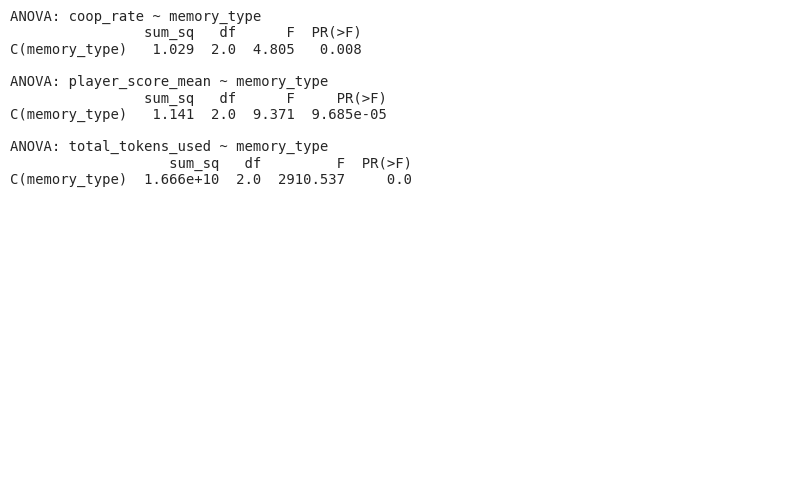

In [111]:
# ------------------------------------------------------------------
# 1.  One-way ANOVA by MEMORY DEPTH  (three groups)
# ------------------------------------------------------------------
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
import matplotlib.pyplot as plt

outcomes = ["coop_rate", "player_score_mean", "total_tokens_used"]
anova_mem = {}
output_lines = []

for y in outcomes:
    model = smf.ols(f"{y} ~ C(memory_type)", data=game_df).fit()
    aov   = anova_lm(model, typ=2)
    anova_mem[y] = aov

    # Print and display the ANOVA row
    print(f"\n=== ANOVA: {y} ~ memory_type ===")
    row = aov.loc["C(memory_type)"]
    display(row)

    # Prepare the ANOVA result for this outcome
    header = f"ANOVA: {y} ~ memory_type"
    table_str = row.to_frame().T.to_string()
    output_lines.append(header)
    output_lines.extend(table_str.split('\n'))
    output_lines.append("")  # blank line between tables

# Dump all ANOVA results into a single PNG
output_str = '\n'.join(output_lines)
lines = output_str.split('\n')
fig, ax = plt.subplots(figsize=(10, max(6, len(lines) * 0.25)))
ax.axis('off')
ax.text(
    0, 1,
    output_str,
    family='monospace',
    fontsize=10,
    va='top',
)
fig.savefig("anova_memory_type_all.png", bbox_inches='tight', dpi=300)



In [112]:
# ------------------------------------------------------------------ 
# 2.  One-way ANOVA by FRAMING CONDITION (24 groups)
#     – if you have more, adjust `condition`
# ------------------------------------------------------------------
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm
import matplotlib.pyplot as plt

outcomes = ["coop_rate", "player_score_mean", "total_tokens_used"]
anova_frm = {}
output_lines = []

for y in outcomes:
    model = smf.ols(f"{y} ~ C(condition)", data=game_df).fit()
    aov   = anova_lm(model, typ=2)
    anova_frm[y] = aov

    print(f"\n=== ANOVA: {y} ~ condition ===")
    row = aov.loc["C(condition)"]
    display(row)

    header = f"ANOVA: {y} ~ condition"
    table_str = row.to_frame().T.to_string()
    output_lines.append(header)
    output_lines.extend(table_str.split('\n'))
    output_lines.append("")  # blank line between tables

# Dump all ANOVA by condition results into a single PNG
output_str = '\n'.join(output_lines)
lines = output_str.split('\n')
fig, ax = plt.subplots(figsize=(10, max(6, len(lines) * 0.25)))
ax.axis('off')
ax.text(
    0, 1,
    output_str,
    family='monospace',
    fontsize=10,
    va='top',
)
fig.savefig("anova_condition_all.png", bbox_inches='tight', dpi=300)



=== ANOVA: coop_rate ~ condition ===


sum_sq    1.263e+01
df        2.300e+01
F         5.923e+00
PR(>F)    3.967e-16
Name: C(condition), dtype: float64


=== ANOVA: player_score_mean ~ condition ===


sum_sq    3.637e+00
df        2.300e+01
F         2.680e+00
PR(>F)    4.025e-05
Name: C(condition), dtype: float64


=== ANOVA: total_tokens_used ~ condition ===


sum_sq    1.940e+08
df        2.300e+01
F         2.986e-01
PR(>F)    9.995e-01
Name: C(condition), dtype: float64